# mini6. Insurance Premium Data Regression
[사용 데이터 정보]   
데이터 출처: https://www.kaggle.com/datasets/simranjain17/insurance   
데이터 이름 : 'Insurance.csv'   
데이터 포맷 : (1338, 7)   


 This Dataset is something I found online when I wanted to practice regression models. It is an openly available online dataset at multiple places. Though I do not know the exact origin and collection methodology of the data, I would recommend this dataset to everybody who is just beginning their journey in Data science.


[특성 구분]   
- age : The Age of the policyholder
- sex : The Gender of the policyholder
- bmi : The Body Mass Index of the Policyholder
- children : Number of Children of the Policyholder
- smoker : A Column whether the Policyholder is Smoker or No Smoker
- region : The Region where the Policyholder belongs to
- charges : The Premium Charged to the Policyholder

## 0. 환경설정

### 라이브러리 호출

In [95]:
# 라이브러리 호출
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import time
import datetime as dt

# 한글 폰트 패치.
matplotlib.rcParams['font.family']='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False  

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# ggplot style skima
plt.style.use("ggplot")

# seaborn plot style definition
sns.set_style("whitegrid")
sns.set_context("talk")

# 경고문 처리
import warnings
warnings.filterwarnings('ignore')

# sklearn.module
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from lightgbm import LGBMRegressor, plot_importance
from sklearn.metrics import mean_squared_error, r2_score

### 시각화 한글 폰트 설정

In [2]:
import platform

def get_font_family():
    system_name = platform.system()

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        !apt-get install fonts-nanum -qq  > /dev/null
        !fc-cache -fv

        import matplotlib as mpl
        mpl.font_manager._rebuild()
        findfont = mpl.font_manager.fontManager.findfont
        mpl.font_manager.findfont = findfont
        mpl.backends.backend_agg.findfont = findfont
        
        font_family = "NanumBarunGothic"
    return font_family

%config InlineBackend.figure_format = 'retina'

plt.rc("font", family=get_font_family())
plt.rc("axes", unicode_minus=False)

get_font_family()

'Malgun Gothic'

### 그래프 색상 그라데이션 설정

In [3]:
def gradientbars(bars,cmap):
    grad = np.expand_dims(np.linspace(0,1,256),0).T
    ax = bars[0].axes 
    lim = ax.get_xlim()+ax.get_ylim() 
    for bar in bars:
        bar.set_facecolor("none") 
        x,y = bar.get_xy() 
        w, h = bar.get_width(), bar.get_height() 
        ax.imshow(grad, extent=[x,x+w,y+h,y], cmap = cmap, aspect="auto",\
                   vmin=-0.5, vmax=2) 
    ax.axis(lim)

### 사용자 정의 함수

In [114]:
def get_reg_eval(y_test,y_pred):
    mse = np.round(mean_squared_error(y_test,y_pred),4)
    rmse = np.round(np.sqrt(mse),4)
    R2_score = np.round(r2_score(y_test,y_pred),4)
    
    print('mse :',mse)
    print('rmse :',rmse)
    print('r2_score :',R2_score)

## 1. Data Load
### Insurance.csv (1338,7)

In [4]:
df = pd.read_csv('data/Insurance.csv')
print('df.shape :',df.shape)
df.head()

df.shape : (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [10]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [13]:
print('cateory data elements:')
print(df['sex'].unique())
print(df['smoker'].unique())
print(df['region'].unique())

cateory data elements:
['female' 'male']
['yes' 'no']
['southwest' 'southeast' 'northwest' 'northeast']


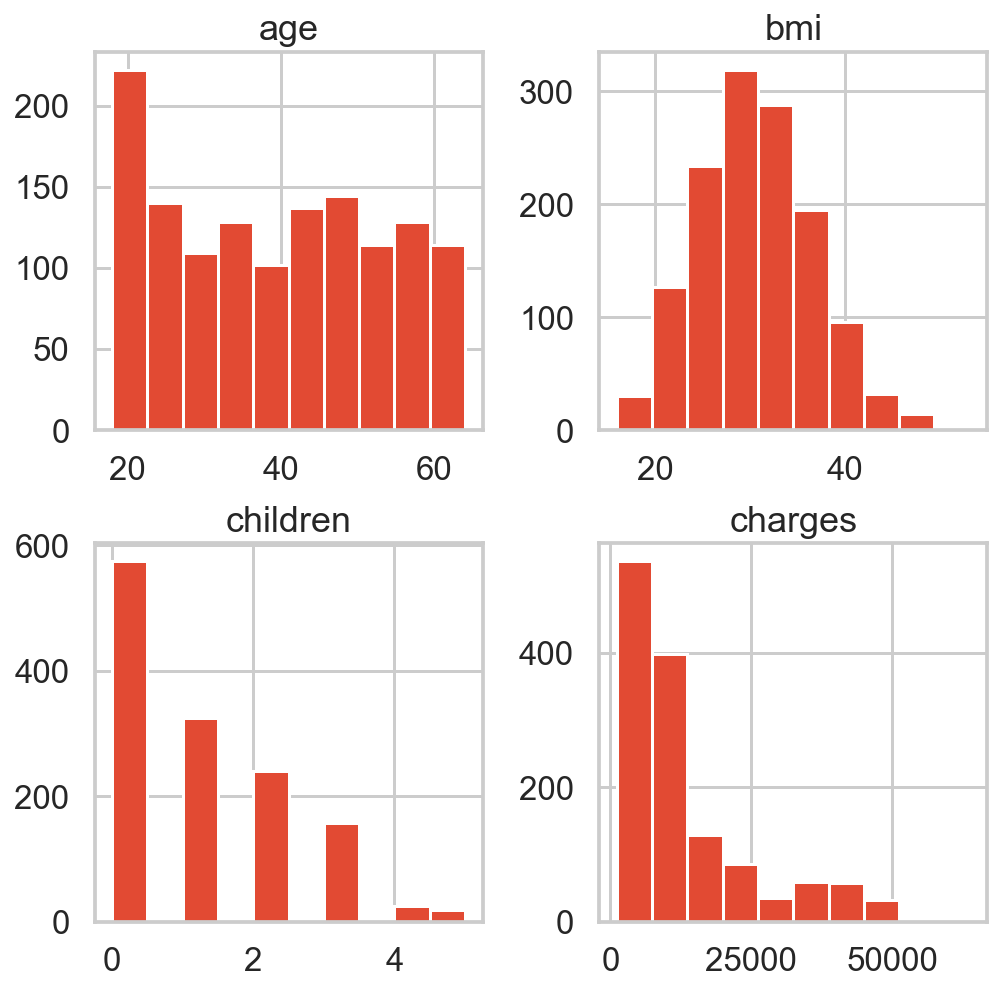

In [9]:
_ = df.hist(figsize=(8,8))

## 2. Data EDA & Preprocessing

In [17]:
X = df.drop('charges',axis=1)
y = df['charges']

In [33]:
X_ohe =  pd.get_dummies(X)
X_ohe.head(2)

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.90,0,1,0,0,1,0,0,0,1
1,18,33.77,1,0,1,1,0,0,0,1,0


In [29]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_ohe)
X_scaled.shape

(1338, 11)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, shuffle=True, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, shuffle=True, test_size=0.2, random_state=42)

print('X_train.shape :',X_train.shape)
print('X_valid.shape :',X_valid.shape)
print('X_test.shape :',X_test.shape)
print('y_train.shape :',y_train.shape)
print('y_valid.shape :',y_valid.shape)
print('y_test.shape :',y_test.shape)

X_train.shape : (856, 11)
X_valid.shape : (214, 11)
X_test.shape : (268, 11)
y_train.shape : (856,)
y_valid.shape : (214,)
y_test.shape : (268,)


## 3. Modeling

In [46]:
lgbm_clf = LGBMRegressor(n_estimators=300)
evals = [(X_valid,y_valid)]

param_grid = {
    'learning_rate':[0.05,0.1,0.2,0.3],
    'subsample':[0.7,0.8,0.9],
    'max_depth':[5,6,7,8,9,10]
}

start_time = time.time()
grid_cv = GridSearchCV(lgbm_clf, cv=3, refit=True, param_grid=param_grid)
grid_cv.fit(X_train, y_train, early_stopping_rounds=50, eval_metric='rmse', eval_set = evals)
end_time = time.time()

[1]	valid_0's rmse: 12127.6	valid_0's l2: 1.47078e+08
Training until validation scores don't improve for 50 rounds
[2]	valid_0's rmse: 11630.5	valid_0's l2: 1.35268e+08
[3]	valid_0's rmse: 11167.8	valid_0's l2: 1.24721e+08
[4]	valid_0's rmse: 10728.9	valid_0's l2: 1.1511e+08
[5]	valid_0's rmse: 10319.5	valid_0's l2: 1.06492e+08
[6]	valid_0's rmse: 9932.11	valid_0's l2: 9.86469e+07
[7]	valid_0's rmse: 9572.66	valid_0's l2: 9.16358e+07
[8]	valid_0's rmse: 9235.61	valid_0's l2: 8.52965e+07
[9]	valid_0's rmse: 8915.41	valid_0's l2: 7.94845e+07
[10]	valid_0's rmse: 8619.2	valid_0's l2: 7.42907e+07
[11]	valid_0's rmse: 8346.84	valid_0's l2: 6.96697e+07
[12]	valid_0's rmse: 8096.06	valid_0's l2: 6.55462e+07
[13]	valid_0's rmse: 7856.36	valid_0's l2: 6.17224e+07
[14]	valid_0's rmse: 7638.61	valid_0's l2: 5.83484e+07
[15]	valid_0's rmse: 7449.33	valid_0's l2: 5.54925e+07
[16]	valid_0's rmse: 7257.37	valid_0's l2: 5.26694e+07
[17]	valid_0's rmse: 7080.99	valid_0's l2: 5.01404e+07
[18]	valid_0's 

[41]	valid_0's rmse: 5477.71	valid_0's l2: 3.00053e+07
[42]	valid_0's rmse: 5465.02	valid_0's l2: 2.98665e+07
[43]	valid_0's rmse: 5457	valid_0's l2: 2.97789e+07
[44]	valid_0's rmse: 5445.57	valid_0's l2: 2.96543e+07
[45]	valid_0's rmse: 5437.66	valid_0's l2: 2.95681e+07
[46]	valid_0's rmse: 5434.18	valid_0's l2: 2.95303e+07
[47]	valid_0's rmse: 5429.23	valid_0's l2: 2.94766e+07
[48]	valid_0's rmse: 5423.19	valid_0's l2: 2.9411e+07
[49]	valid_0's rmse: 5423.35	valid_0's l2: 2.94127e+07
[50]	valid_0's rmse: 5425.02	valid_0's l2: 2.94308e+07
[51]	valid_0's rmse: 5423.08	valid_0's l2: 2.94098e+07
[52]	valid_0's rmse: 5425.95	valid_0's l2: 2.94409e+07
[53]	valid_0's rmse: 5426.84	valid_0's l2: 2.94506e+07
[54]	valid_0's rmse: 5427.9	valid_0's l2: 2.94621e+07
[55]	valid_0's rmse: 5428.06	valid_0's l2: 2.94639e+07
[56]	valid_0's rmse: 5429.97	valid_0's l2: 2.94846e+07
[57]	valid_0's rmse: 5432.83	valid_0's l2: 2.95157e+07
[58]	valid_0's rmse: 5434.57	valid_0's l2: 2.95345e+07
[59]	valid_0's 

[2]	valid_0's rmse: 11630.5	valid_0's l2: 1.35268e+08
[3]	valid_0's rmse: 11167.8	valid_0's l2: 1.24721e+08
[4]	valid_0's rmse: 10728.9	valid_0's l2: 1.1511e+08
[5]	valid_0's rmse: 10319.5	valid_0's l2: 1.06492e+08
[6]	valid_0's rmse: 9932.11	valid_0's l2: 9.86469e+07
[7]	valid_0's rmse: 9572.66	valid_0's l2: 9.16358e+07
[8]	valid_0's rmse: 9235.61	valid_0's l2: 8.52965e+07
[9]	valid_0's rmse: 8915.41	valid_0's l2: 7.94845e+07
[10]	valid_0's rmse: 8619.2	valid_0's l2: 7.42907e+07
[11]	valid_0's rmse: 8346.84	valid_0's l2: 6.96697e+07
[12]	valid_0's rmse: 8096.06	valid_0's l2: 6.55462e+07
[13]	valid_0's rmse: 7856.36	valid_0's l2: 6.17224e+07
[14]	valid_0's rmse: 7638.61	valid_0's l2: 5.83484e+07
[15]	valid_0's rmse: 7449.33	valid_0's l2: 5.54925e+07
[16]	valid_0's rmse: 7257.37	valid_0's l2: 5.26694e+07
[17]	valid_0's rmse: 7080.99	valid_0's l2: 5.01404e+07
[18]	valid_0's rmse: 6933.37	valid_0's l2: 4.80716e+07
[19]	valid_0's rmse: 6783.81	valid_0's l2: 4.602e+07
[20]	valid_0's rmse: 6

[93]	valid_0's rmse: 5467.97	valid_0's l2: 2.98986e+07
[94]	valid_0's rmse: 5471.09	valid_0's l2: 2.99328e+07
[95]	valid_0's rmse: 5472.97	valid_0's l2: 2.99534e+07
[96]	valid_0's rmse: 5475.76	valid_0's l2: 2.9984e+07
[97]	valid_0's rmse: 5477.59	valid_0's l2: 3.0004e+07
[98]	valid_0's rmse: 5475.7	valid_0's l2: 2.99833e+07
[99]	valid_0's rmse: 5476.16	valid_0's l2: 2.99884e+07
[100]	valid_0's rmse: 5477.97	valid_0's l2: 3.00081e+07
[101]	valid_0's rmse: 5480.03	valid_0's l2: 3.00307e+07
Early stopping, best iteration is:
[51]	valid_0's rmse: 5423.08	valid_0's l2: 2.94098e+07
[1]	valid_0's rmse: 12110.3	valid_0's l2: 1.46658e+08
Training until validation scores don't improve for 50 rounds
[2]	valid_0's rmse: 11606.4	valid_0's l2: 1.34708e+08
[3]	valid_0's rmse: 11136.1	valid_0's l2: 1.24013e+08
[4]	valid_0's rmse: 10680.5	valid_0's l2: 1.14073e+08
[5]	valid_0's rmse: 10267.9	valid_0's l2: 1.05429e+08
[6]	valid_0's rmse: 9867.27	valid_0's l2: 9.7363e+07
[7]	valid_0's rmse: 9504.75	vali

[24]	valid_0's rmse: 6211.86	valid_0's l2: 3.85873e+07
[25]	valid_0's rmse: 6124.49	valid_0's l2: 3.75094e+07
[26]	valid_0's rmse: 6048	valid_0's l2: 3.65783e+07
[27]	valid_0's rmse: 5973.32	valid_0's l2: 3.56805e+07
[28]	valid_0's rmse: 5904.92	valid_0's l2: 3.48681e+07
[29]	valid_0's rmse: 5842.8	valid_0's l2: 3.41383e+07
[30]	valid_0's rmse: 5795.24	valid_0's l2: 3.35848e+07
[31]	valid_0's rmse: 5743.72	valid_0's l2: 3.29904e+07
[32]	valid_0's rmse: 5696.47	valid_0's l2: 3.24498e+07
[33]	valid_0's rmse: 5656.95	valid_0's l2: 3.20011e+07
[34]	valid_0's rmse: 5618.66	valid_0's l2: 3.15693e+07
[35]	valid_0's rmse: 5592.11	valid_0's l2: 3.12717e+07
[36]	valid_0's rmse: 5558.81	valid_0's l2: 3.09003e+07
[37]	valid_0's rmse: 5532.79	valid_0's l2: 3.06118e+07
[38]	valid_0's rmse: 5506.15	valid_0's l2: 3.03177e+07
[39]	valid_0's rmse: 5488.98	valid_0's l2: 3.01289e+07
[40]	valid_0's rmse: 5464.24	valid_0's l2: 2.98579e+07
[41]	valid_0's rmse: 5441.18	valid_0's l2: 2.96065e+07
[42]	valid_0's

[73]	valid_0's rmse: 5444.76	valid_0's l2: 2.96454e+07
[74]	valid_0's rmse: 5447.78	valid_0's l2: 2.96783e+07
[75]	valid_0's rmse: 5444.9	valid_0's l2: 2.96469e+07
[76]	valid_0's rmse: 5442.36	valid_0's l2: 2.96192e+07
[77]	valid_0's rmse: 5444.86	valid_0's l2: 2.96465e+07
[78]	valid_0's rmse: 5442.14	valid_0's l2: 2.96169e+07
[79]	valid_0's rmse: 5444.35	valid_0's l2: 2.96409e+07
[80]	valid_0's rmse: 5442.26	valid_0's l2: 2.96182e+07
[81]	valid_0's rmse: 5446.04	valid_0's l2: 2.96594e+07
[82]	valid_0's rmse: 5449.05	valid_0's l2: 2.96921e+07
[83]	valid_0's rmse: 5446.76	valid_0's l2: 2.96672e+07
[84]	valid_0's rmse: 5449.78	valid_0's l2: 2.97001e+07
[85]	valid_0's rmse: 5448.03	valid_0's l2: 2.9681e+07
[86]	valid_0's rmse: 5453.02	valid_0's l2: 2.97355e+07
[87]	valid_0's rmse: 5455.3	valid_0's l2: 2.97603e+07
[88]	valid_0's rmse: 5457.85	valid_0's l2: 2.97881e+07
[89]	valid_0's rmse: 5459.48	valid_0's l2: 2.98059e+07
[90]	valid_0's rmse: 5462.35	valid_0's l2: 2.98372e+07
[91]	valid_0'

[23]	valid_0's rmse: 6301.31	valid_0's l2: 3.97064e+07
[24]	valid_0's rmse: 6204.22	valid_0's l2: 3.84924e+07
[25]	valid_0's rmse: 6118.66	valid_0's l2: 3.7438e+07
[26]	valid_0's rmse: 6038.64	valid_0's l2: 3.64651e+07
[27]	valid_0's rmse: 5963.96	valid_0's l2: 3.55688e+07
[28]	valid_0's rmse: 5902.59	valid_0's l2: 3.48406e+07
[29]	valid_0's rmse: 5841.11	valid_0's l2: 3.41186e+07
[30]	valid_0's rmse: 5791.93	valid_0's l2: 3.35465e+07
[31]	valid_0's rmse: 5739.34	valid_0's l2: 3.294e+07
[32]	valid_0's rmse: 5696.78	valid_0's l2: 3.24533e+07
[33]	valid_0's rmse: 5656.82	valid_0's l2: 3.19996e+07
[34]	valid_0's rmse: 5618.68	valid_0's l2: 3.15695e+07
[35]	valid_0's rmse: 5588.54	valid_0's l2: 3.12318e+07
[36]	valid_0's rmse: 5556.9	valid_0's l2: 3.08791e+07
[37]	valid_0's rmse: 5528.69	valid_0's l2: 3.05664e+07
[38]	valid_0's rmse: 5502.45	valid_0's l2: 3.0277e+07
[39]	valid_0's rmse: 5484.4	valid_0's l2: 3.00787e+07
[40]	valid_0's rmse: 5459.68	valid_0's l2: 2.98081e+07
[41]	valid_0's r

[77]	valid_0's rmse: 5461.67	valid_0's l2: 2.98298e+07
[78]	valid_0's rmse: 5465.14	valid_0's l2: 2.98677e+07
[79]	valid_0's rmse: 5462.51	valid_0's l2: 2.98391e+07
[80]	valid_0's rmse: 5460.07	valid_0's l2: 2.98124e+07
[81]	valid_0's rmse: 5462.85	valid_0's l2: 2.98428e+07
[82]	valid_0's rmse: 5466.05	valid_0's l2: 2.98776e+07
[83]	valid_0's rmse: 5464.4	valid_0's l2: 2.98597e+07
[84]	valid_0's rmse: 5463.45	valid_0's l2: 2.98493e+07
[85]	valid_0's rmse: 5467.7	valid_0's l2: 2.98957e+07
[86]	valid_0's rmse: 5465.72	valid_0's l2: 2.98741e+07
[87]	valid_0's rmse: 5466.92	valid_0's l2: 2.98872e+07
[88]	valid_0's rmse: 5469.82	valid_0's l2: 2.99189e+07
[89]	valid_0's rmse: 5474.65	valid_0's l2: 2.99718e+07
[90]	valid_0's rmse: 5472.69	valid_0's l2: 2.99503e+07
[91]	valid_0's rmse: 5478.03	valid_0's l2: 3.00088e+07
[92]	valid_0's rmse: 5480.71	valid_0's l2: 3.00382e+07
[93]	valid_0's rmse: 5480.36	valid_0's l2: 3.00343e+07
[94]	valid_0's rmse: 5485.49	valid_0's l2: 3.00907e+07
[95]	valid_0

[27]	valid_0's rmse: 5963.96	valid_0's l2: 3.55688e+07
[28]	valid_0's rmse: 5902.59	valid_0's l2: 3.48406e+07
[29]	valid_0's rmse: 5841.11	valid_0's l2: 3.41186e+07
[30]	valid_0's rmse: 5791.93	valid_0's l2: 3.35465e+07
[31]	valid_0's rmse: 5739.34	valid_0's l2: 3.294e+07
[32]	valid_0's rmse: 5696.78	valid_0's l2: 3.24533e+07
[33]	valid_0's rmse: 5656.82	valid_0's l2: 3.19996e+07
[34]	valid_0's rmse: 5618.68	valid_0's l2: 3.15695e+07
[35]	valid_0's rmse: 5588.54	valid_0's l2: 3.12318e+07
[36]	valid_0's rmse: 5556.9	valid_0's l2: 3.08791e+07
[37]	valid_0's rmse: 5528.69	valid_0's l2: 3.05664e+07
[38]	valid_0's rmse: 5502.45	valid_0's l2: 3.0277e+07
[39]	valid_0's rmse: 5484.4	valid_0's l2: 3.00787e+07
[40]	valid_0's rmse: 5459.68	valid_0's l2: 2.98081e+07
[41]	valid_0's rmse: 5437.02	valid_0's l2: 2.95612e+07
[42]	valid_0's rmse: 5428.57	valid_0's l2: 2.94693e+07
[43]	valid_0's rmse: 5411.18	valid_0's l2: 2.92808e+07
[44]	valid_0's rmse: 5400.5	valid_0's l2: 2.91654e+07
[45]	valid_0's r

[91]	valid_0's rmse: 5364.35	valid_0's l2: 2.87763e+07
[92]	valid_0's rmse: 5366.56	valid_0's l2: 2.87999e+07
[93]	valid_0's rmse: 5368.06	valid_0's l2: 2.88161e+07
[94]	valid_0's rmse: 5369.87	valid_0's l2: 2.88355e+07
[95]	valid_0's rmse: 5371.58	valid_0's l2: 2.88539e+07
[96]	valid_0's rmse: 5373.94	valid_0's l2: 2.88792e+07
[97]	valid_0's rmse: 5378.97	valid_0's l2: 2.89333e+07
[98]	valid_0's rmse: 5383.56	valid_0's l2: 2.89828e+07
[99]	valid_0's rmse: 5387.47	valid_0's l2: 2.90248e+07
[100]	valid_0's rmse: 5387.12	valid_0's l2: 2.90211e+07
[101]	valid_0's rmse: 5388.11	valid_0's l2: 2.90317e+07
[102]	valid_0's rmse: 5387.13	valid_0's l2: 2.90212e+07
[103]	valid_0's rmse: 5390.96	valid_0's l2: 2.90624e+07
[104]	valid_0's rmse: 5392.71	valid_0's l2: 2.90813e+07
[105]	valid_0's rmse: 5396.47	valid_0's l2: 2.91219e+07
[106]	valid_0's rmse: 5396.97	valid_0's l2: 2.91273e+07
[107]	valid_0's rmse: 5396.33	valid_0's l2: 2.91204e+07
[108]	valid_0's rmse: 5397.56	valid_0's l2: 2.91336e+07
[

[2]	valid_0's rmse: 11617.3	valid_0's l2: 1.34961e+08
[3]	valid_0's rmse: 11145.8	valid_0's l2: 1.24229e+08
[4]	valid_0's rmse: 10701.5	valid_0's l2: 1.14523e+08
[5]	valid_0's rmse: 10287.4	valid_0's l2: 1.0583e+08
[6]	valid_0's rmse: 9898.69	valid_0's l2: 9.7984e+07
[7]	valid_0's rmse: 9536.09	valid_0's l2: 9.0937e+07
[8]	valid_0's rmse: 9201.72	valid_0's l2: 8.46717e+07
[9]	valid_0's rmse: 8884.82	valid_0's l2: 7.89401e+07
[10]	valid_0's rmse: 8592.08	valid_0's l2: 7.38238e+07
[11]	valid_0's rmse: 8317.87	valid_0's l2: 6.91869e+07
[12]	valid_0's rmse: 8065.57	valid_0's l2: 6.50534e+07
[13]	valid_0's rmse: 7827.39	valid_0's l2: 6.12681e+07
[14]	valid_0's rmse: 7606.39	valid_0's l2: 5.78572e+07
[15]	valid_0's rmse: 7406.42	valid_0's l2: 5.48551e+07
[16]	valid_0's rmse: 7225.23	valid_0's l2: 5.2204e+07
[17]	valid_0's rmse: 7051.07	valid_0's l2: 4.97175e+07
[18]	valid_0's rmse: 6893.35	valid_0's l2: 4.75183e+07
[19]	valid_0's rmse: 6750.61	valid_0's l2: 4.55708e+07
[20]	valid_0's rmse: 6

[57]	valid_0's rmse: 5331.05	valid_0's l2: 2.84201e+07
[58]	valid_0's rmse: 5326.45	valid_0's l2: 2.8371e+07
[59]	valid_0's rmse: 5323.79	valid_0's l2: 2.83427e+07
[60]	valid_0's rmse: 5322.15	valid_0's l2: 2.83253e+07
[61]	valid_0's rmse: 5322.89	valid_0's l2: 2.83332e+07
[62]	valid_0's rmse: 5323.9	valid_0's l2: 2.83439e+07
[63]	valid_0's rmse: 5323.61	valid_0's l2: 2.83408e+07
[64]	valid_0's rmse: 5322.13	valid_0's l2: 2.8325e+07
[65]	valid_0's rmse: 5319.82	valid_0's l2: 2.83004e+07
[66]	valid_0's rmse: 5318.53	valid_0's l2: 2.82868e+07
[67]	valid_0's rmse: 5317.22	valid_0's l2: 2.82728e+07
[68]	valid_0's rmse: 5315.63	valid_0's l2: 2.82559e+07
[69]	valid_0's rmse: 5314.78	valid_0's l2: 2.82469e+07
[70]	valid_0's rmse: 5317.21	valid_0's l2: 2.82728e+07
[71]	valid_0's rmse: 5316.13	valid_0's l2: 2.82612e+07
[72]	valid_0's rmse: 5316.2	valid_0's l2: 2.8262e+07
[73]	valid_0's rmse: 5315.65	valid_0's l2: 2.82562e+07
[74]	valid_0's rmse: 5315.93	valid_0's l2: 2.82591e+07
[75]	valid_0's 

[108]	valid_0's rmse: 5363.38	valid_0's l2: 2.87659e+07
[109]	valid_0's rmse: 5365.13	valid_0's l2: 2.87847e+07
Early stopping, best iteration is:
[59]	valid_0's rmse: 5305.98	valid_0's l2: 2.81534e+07
[1]	valid_0's rmse: 12122.1	valid_0's l2: 1.46944e+08
Training until validation scores don't improve for 50 rounds
[2]	valid_0's rmse: 11616.3	valid_0's l2: 1.34939e+08
[3]	valid_0's rmse: 11144.3	valid_0's l2: 1.24196e+08
[4]	valid_0's rmse: 10699.6	valid_0's l2: 1.14482e+08
[5]	valid_0's rmse: 10285.3	valid_0's l2: 1.05788e+08
[6]	valid_0's rmse: 9896.75	valid_0's l2: 9.79457e+07
[7]	valid_0's rmse: 9535.72	valid_0's l2: 9.093e+07
[8]	valid_0's rmse: 9200.94	valid_0's l2: 8.46573e+07
[9]	valid_0's rmse: 8882.91	valid_0's l2: 7.89061e+07
[10]	valid_0's rmse: 8589.5	valid_0's l2: 7.37796e+07
[11]	valid_0's rmse: 8314.07	valid_0's l2: 6.91237e+07
[12]	valid_0's rmse: 8061.77	valid_0's l2: 6.49922e+07
[13]	valid_0's rmse: 7824.79	valid_0's l2: 6.12273e+07
[14]	valid_0's rmse: 7603.17	valid

[49]	valid_0's rmse: 5354.45	valid_0's l2: 2.86702e+07
[50]	valid_0's rmse: 5348.33	valid_0's l2: 2.86047e+07
[51]	valid_0's rmse: 5341.21	valid_0's l2: 2.85286e+07
[52]	valid_0's rmse: 5332.84	valid_0's l2: 2.84391e+07
[53]	valid_0's rmse: 5324.8	valid_0's l2: 2.83535e+07
[54]	valid_0's rmse: 5319.72	valid_0's l2: 2.82994e+07
[55]	valid_0's rmse: 5313.25	valid_0's l2: 2.82306e+07
[56]	valid_0's rmse: 5311.63	valid_0's l2: 2.82134e+07
[57]	valid_0's rmse: 5309.77	valid_0's l2: 2.81937e+07
[58]	valid_0's rmse: 5310.16	valid_0's l2: 2.81978e+07
[59]	valid_0's rmse: 5305.98	valid_0's l2: 2.81534e+07
[60]	valid_0's rmse: 5308.46	valid_0's l2: 2.81798e+07
[61]	valid_0's rmse: 5306.68	valid_0's l2: 2.81609e+07
[62]	valid_0's rmse: 5308.67	valid_0's l2: 2.8182e+07
[63]	valid_0's rmse: 5309.32	valid_0's l2: 2.81889e+07
[64]	valid_0's rmse: 5310.78	valid_0's l2: 2.82044e+07
[65]	valid_0's rmse: 5308.09	valid_0's l2: 2.81759e+07
[66]	valid_0's rmse: 5309.17	valid_0's l2: 2.81873e+07
[67]	valid_0

[86]	valid_0's rmse: 5359.6	valid_0's l2: 2.87253e+07
[87]	valid_0's rmse: 5362.59	valid_0's l2: 2.87574e+07
[88]	valid_0's rmse: 5361.76	valid_0's l2: 2.87484e+07
[89]	valid_0's rmse: 5366.52	valid_0's l2: 2.87996e+07
[90]	valid_0's rmse: 5369.54	valid_0's l2: 2.88319e+07
[91]	valid_0's rmse: 5372.08	valid_0's l2: 2.88592e+07
[92]	valid_0's rmse: 5376.05	valid_0's l2: 2.89019e+07
[93]	valid_0's rmse: 5373.74	valid_0's l2: 2.88771e+07
[94]	valid_0's rmse: 5378.43	valid_0's l2: 2.89275e+07
[95]	valid_0's rmse: 5383.95	valid_0's l2: 2.8987e+07
[96]	valid_0's rmse: 5384.37	valid_0's l2: 2.89915e+07
[97]	valid_0's rmse: 5383.92	valid_0's l2: 2.89865e+07
[98]	valid_0's rmse: 5382.93	valid_0's l2: 2.89759e+07
[99]	valid_0's rmse: 5381.94	valid_0's l2: 2.89653e+07
[100]	valid_0's rmse: 5381.15	valid_0's l2: 2.89568e+07
[101]	valid_0's rmse: 5383.61	valid_0's l2: 2.89833e+07
[102]	valid_0's rmse: 5386.54	valid_0's l2: 2.90148e+07
[103]	valid_0's rmse: 5390.01	valid_0's l2: 2.90522e+07
[104]	va

[29]	valid_0's rmse: 5748.38	valid_0's l2: 3.30439e+07
[30]	valid_0's rmse: 5696.87	valid_0's l2: 3.24543e+07
[31]	valid_0's rmse: 5651.02	valid_0's l2: 3.1934e+07
[32]	valid_0's rmse: 5608.67	valid_0's l2: 3.14571e+07
[33]	valid_0's rmse: 5572.31	valid_0's l2: 3.10507e+07
[34]	valid_0's rmse: 5539.45	valid_0's l2: 3.06856e+07
[35]	valid_0's rmse: 5511.95	valid_0's l2: 3.03816e+07
[36]	valid_0's rmse: 5488.56	valid_0's l2: 3.01243e+07
[37]	valid_0's rmse: 5460.68	valid_0's l2: 2.9819e+07
[38]	valid_0's rmse: 5441.24	valid_0's l2: 2.96071e+07
[39]	valid_0's rmse: 5427.16	valid_0's l2: 2.94541e+07
[40]	valid_0's rmse: 5414.47	valid_0's l2: 2.93165e+07
[41]	valid_0's rmse: 5399.79	valid_0's l2: 2.91578e+07
[42]	valid_0's rmse: 5392	valid_0's l2: 2.90737e+07
[43]	valid_0's rmse: 5384.83	valid_0's l2: 2.89964e+07
[44]	valid_0's rmse: 5379.85	valid_0's l2: 2.89428e+07
[45]	valid_0's rmse: 5370.45	valid_0's l2: 2.88417e+07
[46]	valid_0's rmse: 5367.94	valid_0's l2: 2.88148e+07
[47]	valid_0's 

[93]	valid_0's rmse: 5324.1	valid_0's l2: 2.83461e+07
[94]	valid_0's rmse: 5331.21	valid_0's l2: 2.84218e+07
[95]	valid_0's rmse: 5331.85	valid_0's l2: 2.84286e+07
[96]	valid_0's rmse: 5338.4	valid_0's l2: 2.84985e+07
[97]	valid_0's rmse: 5339.16	valid_0's l2: 2.85066e+07
[98]	valid_0's rmse: 5342.36	valid_0's l2: 2.85408e+07
[99]	valid_0's rmse: 5345.47	valid_0's l2: 2.8574e+07
[100]	valid_0's rmse: 5347.22	valid_0's l2: 2.85928e+07
[101]	valid_0's rmse: 5352.22	valid_0's l2: 2.86463e+07
[102]	valid_0's rmse: 5349.96	valid_0's l2: 2.8622e+07
[103]	valid_0's rmse: 5351.67	valid_0's l2: 2.86404e+07
[104]	valid_0's rmse: 5356.06	valid_0's l2: 2.86874e+07
[105]	valid_0's rmse: 5359.87	valid_0's l2: 2.87282e+07
[106]	valid_0's rmse: 5364.55	valid_0's l2: 2.87784e+07
[107]	valid_0's rmse: 5368.47	valid_0's l2: 2.88205e+07
[108]	valid_0's rmse: 5368.41	valid_0's l2: 2.88198e+07
[109]	valid_0's rmse: 5372.61	valid_0's l2: 2.8865e+07
[110]	valid_0's rmse: 5376.1	valid_0's l2: 2.89024e+07
[111]

[28]	valid_0's rmse: 5802.07	valid_0's l2: 3.36641e+07
[29]	valid_0's rmse: 5748.41	valid_0's l2: 3.30443e+07
[30]	valid_0's rmse: 5696.93	valid_0's l2: 3.2455e+07
[31]	valid_0's rmse: 5651.66	valid_0's l2: 3.19413e+07
[32]	valid_0's rmse: 5613.97	valid_0's l2: 3.15167e+07
[33]	valid_0's rmse: 5577.89	valid_0's l2: 3.11128e+07
[34]	valid_0's rmse: 5546.73	valid_0's l2: 3.07663e+07
[35]	valid_0's rmse: 5511.05	valid_0's l2: 3.03717e+07
[36]	valid_0's rmse: 5479.75	valid_0's l2: 3.00277e+07
[37]	valid_0's rmse: 5458.19	valid_0's l2: 2.97918e+07
[38]	valid_0's rmse: 5431.44	valid_0's l2: 2.95005e+07
[39]	valid_0's rmse: 5409.86	valid_0's l2: 2.92665e+07
[40]	valid_0's rmse: 5390.16	valid_0's l2: 2.90538e+07
[41]	valid_0's rmse: 5375.46	valid_0's l2: 2.88955e+07
[42]	valid_0's rmse: 5365.25	valid_0's l2: 2.87859e+07
[43]	valid_0's rmse: 5358.03	valid_0's l2: 2.87084e+07
[44]	valid_0's rmse: 5348.65	valid_0's l2: 2.86081e+07
[45]	valid_0's rmse: 5341.22	valid_0's l2: 2.85287e+07
[46]	valid_

[80]	valid_0's rmse: 5309.39	valid_0's l2: 2.81896e+07
[81]	valid_0's rmse: 5307.65	valid_0's l2: 2.81711e+07
[82]	valid_0's rmse: 5307.57	valid_0's l2: 2.81703e+07
[83]	valid_0's rmse: 5307.7	valid_0's l2: 2.81717e+07
[84]	valid_0's rmse: 5309.74	valid_0's l2: 2.81933e+07
[85]	valid_0's rmse: 5308.71	valid_0's l2: 2.81824e+07
[86]	valid_0's rmse: 5307.9	valid_0's l2: 2.81738e+07
[87]	valid_0's rmse: 5308.66	valid_0's l2: 2.81818e+07
[88]	valid_0's rmse: 5310.22	valid_0's l2: 2.81984e+07
[89]	valid_0's rmse: 5313.08	valid_0's l2: 2.82288e+07
[90]	valid_0's rmse: 5314.53	valid_0's l2: 2.82442e+07
[91]	valid_0's rmse: 5320.67	valid_0's l2: 2.83096e+07
[92]	valid_0's rmse: 5319.93	valid_0's l2: 2.83017e+07
[93]	valid_0's rmse: 5324.1	valid_0's l2: 2.83461e+07
[94]	valid_0's rmse: 5331.21	valid_0's l2: 2.84218e+07
[95]	valid_0's rmse: 5331.85	valid_0's l2: 2.84286e+07
[96]	valid_0's rmse: 5338.4	valid_0's l2: 2.84985e+07
[97]	valid_0's rmse: 5339.16	valid_0's l2: 2.85066e+07
[98]	valid_0's

[29]	valid_0's rmse: 5830.21	valid_0's l2: 3.39914e+07
[30]	valid_0's rmse: 5782.01	valid_0's l2: 3.34317e+07
[31]	valid_0's rmse: 5729.6	valid_0's l2: 3.28283e+07
[32]	valid_0's rmse: 5685.07	valid_0's l2: 3.232e+07
[33]	valid_0's rmse: 5643.33	valid_0's l2: 3.18471e+07
[34]	valid_0's rmse: 5611.55	valid_0's l2: 3.14895e+07
[35]	valid_0's rmse: 5578.61	valid_0's l2: 3.11208e+07
[36]	valid_0's rmse: 5544.02	valid_0's l2: 3.07362e+07
[37]	valid_0's rmse: 5515.42	valid_0's l2: 3.04199e+07
[38]	valid_0's rmse: 5490.84	valid_0's l2: 3.01493e+07
[39]	valid_0's rmse: 5469.54	valid_0's l2: 2.99159e+07
[40]	valid_0's rmse: 5446.59	valid_0's l2: 2.96653e+07
[41]	valid_0's rmse: 5428.61	valid_0's l2: 2.94698e+07
[42]	valid_0's rmse: 5420.5	valid_0's l2: 2.93818e+07
[43]	valid_0's rmse: 5405.04	valid_0's l2: 2.92145e+07
[44]	valid_0's rmse: 5385.65	valid_0's l2: 2.90052e+07
[45]	valid_0's rmse: 5381.05	valid_0's l2: 2.89557e+07
[46]	valid_0's rmse: 5373.89	valid_0's l2: 2.88787e+07
[47]	valid_0's

[110]	valid_0's rmse: 5420.64	valid_0's l2: 2.93833e+07
[111]	valid_0's rmse: 5419.9	valid_0's l2: 2.93753e+07
[112]	valid_0's rmse: 5423.01	valid_0's l2: 2.9409e+07
[113]	valid_0's rmse: 5426.95	valid_0's l2: 2.94517e+07
[114]	valid_0's rmse: 5426.21	valid_0's l2: 2.94437e+07
[115]	valid_0's rmse: 5425.5	valid_0's l2: 2.9436e+07
[116]	valid_0's rmse: 5427.76	valid_0's l2: 2.94606e+07
Early stopping, best iteration is:
[66]	valid_0's rmse: 5297.24	valid_0's l2: 2.80607e+07
[1]	valid_0's rmse: 12125.6	valid_0's l2: 1.4703e+08
Training until validation scores don't improve for 50 rounds
[2]	valid_0's rmse: 11626.6	valid_0's l2: 1.35177e+08
[3]	valid_0's rmse: 11162.8	valid_0's l2: 1.24608e+08
[4]	valid_0's rmse: 10723.6	valid_0's l2: 1.14995e+08
[5]	valid_0's rmse: 10312	valid_0's l2: 1.06337e+08
[6]	valid_0's rmse: 9924.14	valid_0's l2: 9.84885e+07
[7]	valid_0's rmse: 9563.91	valid_0's l2: 9.14684e+07
[8]	valid_0's rmse: 9226.77	valid_0's l2: 8.51333e+07
[9]	valid_0's rmse: 8906.18	vali

[37]	valid_0's rmse: 5457.71	valid_0's l2: 2.97865e+07
[38]	valid_0's rmse: 5430.99	valid_0's l2: 2.94957e+07
[39]	valid_0's rmse: 5409.42	valid_0's l2: 2.92618e+07
[40]	valid_0's rmse: 5389.72	valid_0's l2: 2.90491e+07
[41]	valid_0's rmse: 5375.03	valid_0's l2: 2.8891e+07
[42]	valid_0's rmse: 5363.84	valid_0's l2: 2.87707e+07
[43]	valid_0's rmse: 5355.93	valid_0's l2: 2.8686e+07
[44]	valid_0's rmse: 5348.78	valid_0's l2: 2.86094e+07
[45]	valid_0's rmse: 5341.3	valid_0's l2: 2.85295e+07
[46]	valid_0's rmse: 5334.74	valid_0's l2: 2.84595e+07
[47]	valid_0's rmse: 5332.58	valid_0's l2: 2.84364e+07
[48]	valid_0's rmse: 5332.5	valid_0's l2: 2.84356e+07
[49]	valid_0's rmse: 5331.17	valid_0's l2: 2.84214e+07
[50]	valid_0's rmse: 5328.09	valid_0's l2: 2.83886e+07
[51]	valid_0's rmse: 5324.43	valid_0's l2: 2.83496e+07
[52]	valid_0's rmse: 5322.47	valid_0's l2: 2.83287e+07
[53]	valid_0's rmse: 5314.26	valid_0's l2: 2.82414e+07
[54]	valid_0's rmse: 5314.08	valid_0's l2: 2.82394e+07
[55]	valid_0's

[87]	valid_0's rmse: 5499.7	valid_0's l2: 3.02467e+07
[88]	valid_0's rmse: 5497.51	valid_0's l2: 3.02226e+07
[89]	valid_0's rmse: 5502.91	valid_0's l2: 3.0282e+07
[90]	valid_0's rmse: 5503.17	valid_0's l2: 3.02849e+07
[91]	valid_0's rmse: 5509.09	valid_0's l2: 3.03501e+07
[92]	valid_0's rmse: 5511.12	valid_0's l2: 3.03724e+07
[93]	valid_0's rmse: 5514.58	valid_0's l2: 3.04106e+07
[94]	valid_0's rmse: 5514.67	valid_0's l2: 3.04116e+07
[95]	valid_0's rmse: 5518.13	valid_0's l2: 3.04498e+07
[96]	valid_0's rmse: 5517.02	valid_0's l2: 3.04375e+07
[97]	valid_0's rmse: 5515.33	valid_0's l2: 3.04188e+07
[98]	valid_0's rmse: 5515.77	valid_0's l2: 3.04238e+07
[99]	valid_0's rmse: 5516.18	valid_0's l2: 3.04283e+07
[100]	valid_0's rmse: 5513.75	valid_0's l2: 3.04015e+07
[101]	valid_0's rmse: 5514.72	valid_0's l2: 3.04121e+07
[102]	valid_0's rmse: 5519.27	valid_0's l2: 3.04624e+07
[103]	valid_0's rmse: 5518.7	valid_0's l2: 3.0456e+07
Early stopping, best iteration is:
[53]	valid_0's rmse: 5444.4	va

[18]	valid_0's rmse: 6885.16	valid_0's l2: 4.74055e+07
[19]	valid_0's rmse: 6743.63	valid_0's l2: 4.54766e+07
[20]	valid_0's rmse: 6610.83	valid_0's l2: 4.3703e+07
[21]	valid_0's rmse: 6494.02	valid_0's l2: 4.21723e+07
[22]	valid_0's rmse: 6382.6	valid_0's l2: 4.07376e+07
[23]	valid_0's rmse: 6283.37	valid_0's l2: 3.94808e+07
[24]	valid_0's rmse: 6189.73	valid_0's l2: 3.83128e+07
[25]	valid_0's rmse: 6108.46	valid_0's l2: 3.73133e+07
[26]	valid_0's rmse: 6032.88	valid_0's l2: 3.63957e+07
[27]	valid_0's rmse: 5964.06	valid_0's l2: 3.557e+07
[28]	valid_0's rmse: 5903.47	valid_0's l2: 3.48509e+07
[29]	valid_0's rmse: 5849.8	valid_0's l2: 3.42202e+07
[30]	valid_0's rmse: 5803.59	valid_0's l2: 3.36817e+07
[31]	valid_0's rmse: 5753.37	valid_0's l2: 3.31013e+07
[32]	valid_0's rmse: 5710.57	valid_0's l2: 3.26106e+07
[33]	valid_0's rmse: 5677.36	valid_0's l2: 3.22324e+07
[34]	valid_0's rmse: 5640.33	valid_0's l2: 3.18133e+07
[35]	valid_0's rmse: 5613.54	valid_0's l2: 3.15119e+07
[36]	valid_0's 

[38]	valid_0's rmse: 5484.19	valid_0's l2: 3.00763e+07
[39]	valid_0's rmse: 5462.96	valid_0's l2: 2.98439e+07
[40]	valid_0's rmse: 5439.77	valid_0's l2: 2.95911e+07
[41]	valid_0's rmse: 5422.29	valid_0's l2: 2.94012e+07
[42]	valid_0's rmse: 5414.17	valid_0's l2: 2.93133e+07
[43]	valid_0's rmse: 5398.64	valid_0's l2: 2.91453e+07
[44]	valid_0's rmse: 5384.88	valid_0's l2: 2.89969e+07
[45]	valid_0's rmse: 5379.15	valid_0's l2: 2.89353e+07
[46]	valid_0's rmse: 5373.1	valid_0's l2: 2.88702e+07
[47]	valid_0's rmse: 5362.61	valid_0's l2: 2.87576e+07
[48]	valid_0's rmse: 5356.08	valid_0's l2: 2.86876e+07
[49]	valid_0's rmse: 5346.33	valid_0's l2: 2.85833e+07
[50]	valid_0's rmse: 5337.26	valid_0's l2: 2.84863e+07
[51]	valid_0's rmse: 5333.12	valid_0's l2: 2.84422e+07
[52]	valid_0's rmse: 5328.94	valid_0's l2: 2.83976e+07
[53]	valid_0's rmse: 5321.24	valid_0's l2: 2.83155e+07
[54]	valid_0's rmse: 5312.16	valid_0's l2: 2.8219e+07
[55]	valid_0's rmse: 5306.37	valid_0's l2: 2.81576e+07
[56]	valid_0

[1]	valid_0's rmse: 12125.6	valid_0's l2: 1.4703e+08
Training until validation scores don't improve for 50 rounds
[2]	valid_0's rmse: 11626.6	valid_0's l2: 1.35177e+08
[3]	valid_0's rmse: 11162.8	valid_0's l2: 1.24608e+08
[4]	valid_0's rmse: 10723.6	valid_0's l2: 1.14995e+08
[5]	valid_0's rmse: 10312	valid_0's l2: 1.06337e+08
[6]	valid_0's rmse: 9924.14	valid_0's l2: 9.84885e+07
[7]	valid_0's rmse: 9563.91	valid_0's l2: 9.14684e+07
[8]	valid_0's rmse: 9226.77	valid_0's l2: 8.51333e+07
[9]	valid_0's rmse: 8906.18	valid_0's l2: 7.932e+07
[10]	valid_0's rmse: 8610.23	valid_0's l2: 7.41361e+07
[11]	valid_0's rmse: 8337.35	valid_0's l2: 6.95113e+07
[12]	valid_0's rmse: 8086.69	valid_0's l2: 6.53945e+07
[13]	valid_0's rmse: 7849.38	valid_0's l2: 6.16127e+07
[14]	valid_0's rmse: 7628.16	valid_0's l2: 5.81888e+07
[15]	valid_0's rmse: 7436.7	valid_0's l2: 5.53045e+07
[16]	valid_0's rmse: 7250.35	valid_0's l2: 5.25675e+07
[17]	valid_0's rmse: 7074.22	valid_0's l2: 5.00446e+07
[18]	valid_0's rmse

[33]	valid_0's rmse: 5577.89	valid_0's l2: 3.11128e+07
[34]	valid_0's rmse: 5546.73	valid_0's l2: 3.07663e+07
[35]	valid_0's rmse: 5511.05	valid_0's l2: 3.03717e+07
[36]	valid_0's rmse: 5479.75	valid_0's l2: 3.00277e+07
[37]	valid_0's rmse: 5457.71	valid_0's l2: 2.97865e+07
[38]	valid_0's rmse: 5430.99	valid_0's l2: 2.94957e+07
[39]	valid_0's rmse: 5409.42	valid_0's l2: 2.92618e+07
[40]	valid_0's rmse: 5389.72	valid_0's l2: 2.90491e+07
[41]	valid_0's rmse: 5375.03	valid_0's l2: 2.8891e+07
[42]	valid_0's rmse: 5363.84	valid_0's l2: 2.87707e+07
[43]	valid_0's rmse: 5355.93	valid_0's l2: 2.8686e+07
[44]	valid_0's rmse: 5348.78	valid_0's l2: 2.86094e+07
[45]	valid_0's rmse: 5341.3	valid_0's l2: 2.85295e+07
[46]	valid_0's rmse: 5334.74	valid_0's l2: 2.84595e+07
[47]	valid_0's rmse: 5332.58	valid_0's l2: 2.84364e+07
[48]	valid_0's rmse: 5332.75	valid_0's l2: 2.84383e+07
[49]	valid_0's rmse: 5331.14	valid_0's l2: 2.8421e+07
[50]	valid_0's rmse: 5328.05	valid_0's l2: 2.83881e+07
[51]	valid_0's

[79]	valid_0's rmse: 5490.91	valid_0's l2: 3.01501e+07
[80]	valid_0's rmse: 5488.68	valid_0's l2: 3.01256e+07
[81]	valid_0's rmse: 5487	valid_0's l2: 3.01072e+07
[82]	valid_0's rmse: 5488.32	valid_0's l2: 3.01217e+07
[83]	valid_0's rmse: 5490.27	valid_0's l2: 3.0143e+07
[84]	valid_0's rmse: 5496.74	valid_0's l2: 3.02141e+07
[85]	valid_0's rmse: 5493.39	valid_0's l2: 3.01774e+07
[86]	valid_0's rmse: 5500.21	valid_0's l2: 3.02523e+07
[87]	valid_0's rmse: 5498.05	valid_0's l2: 3.02286e+07
[88]	valid_0's rmse: 5495.06	valid_0's l2: 3.01956e+07
[89]	valid_0's rmse: 5501.41	valid_0's l2: 3.02655e+07
[90]	valid_0's rmse: 5501.33	valid_0's l2: 3.02646e+07
[91]	valid_0's rmse: 5504.96	valid_0's l2: 3.03045e+07
[92]	valid_0's rmse: 5510.14	valid_0's l2: 3.03616e+07
[93]	valid_0's rmse: 5513.32	valid_0's l2: 3.03967e+07
[94]	valid_0's rmse: 5517.48	valid_0's l2: 3.04426e+07
[95]	valid_0's rmse: 5517.75	valid_0's l2: 3.04456e+07
[96]	valid_0's rmse: 5519.31	valid_0's l2: 3.04627e+07
[97]	valid_0's

[71]	valid_0's rmse: 5491.22	valid_0's l2: 3.01535e+07
[72]	valid_0's rmse: 5492.07	valid_0's l2: 3.01628e+07
[73]	valid_0's rmse: 5494.04	valid_0's l2: 3.01844e+07
[74]	valid_0's rmse: 5491.92	valid_0's l2: 3.01612e+07
[75]	valid_0's rmse: 5496.1	valid_0's l2: 3.02072e+07
[76]	valid_0's rmse: 5498.17	valid_0's l2: 3.02299e+07
Early stopping, best iteration is:
[26]	valid_0's rmse: 5422.69	valid_0's l2: 2.94056e+07
[1]	valid_0's rmse: 11570.8	valid_0's l2: 1.33884e+08
Training until validation scores don't improve for 50 rounds
[2]	valid_0's rmse: 10640.9	valid_0's l2: 1.13229e+08
[3]	valid_0's rmse: 9819.44	valid_0's l2: 9.64213e+07
[4]	valid_0's rmse: 9080.36	valid_0's l2: 8.24529e+07
[5]	valid_0's rmse: 8469.71	valid_0's l2: 7.17359e+07
[6]	valid_0's rmse: 7934.82	valid_0's l2: 6.29614e+07
[7]	valid_0's rmse: 7482.04	valid_0's l2: 5.59809e+07
[8]	valid_0's rmse: 7074.46	valid_0's l2: 5.00479e+07
[9]	valid_0's rmse: 6748.72	valid_0's l2: 4.55453e+07
[10]	valid_0's rmse: 6465.12	valid

[60]	valid_0's rmse: 5375.52	valid_0's l2: 2.88962e+07
[61]	valid_0's rmse: 5377.21	valid_0's l2: 2.89144e+07
[62]	valid_0's rmse: 5378.28	valid_0's l2: 2.89259e+07
[63]	valid_0's rmse: 5374.56	valid_0's l2: 2.88859e+07
[64]	valid_0's rmse: 5372.98	valid_0's l2: 2.88689e+07
[65]	valid_0's rmse: 5376.21	valid_0's l2: 2.89037e+07
[66]	valid_0's rmse: 5370.74	valid_0's l2: 2.88448e+07
[67]	valid_0's rmse: 5378.08	valid_0's l2: 2.89237e+07
[68]	valid_0's rmse: 5372.54	valid_0's l2: 2.88642e+07
[69]	valid_0's rmse: 5377.9	valid_0's l2: 2.89218e+07
[70]	valid_0's rmse: 5377.1	valid_0's l2: 2.89132e+07
[71]	valid_0's rmse: 5386.02	valid_0's l2: 2.90092e+07
[72]	valid_0's rmse: 5388.23	valid_0's l2: 2.90331e+07
[73]	valid_0's rmse: 5388.08	valid_0's l2: 2.90314e+07
[74]	valid_0's rmse: 5389.98	valid_0's l2: 2.90519e+07
[75]	valid_0's rmse: 5388.83	valid_0's l2: 2.90395e+07
[76]	valid_0's rmse: 5392.35	valid_0's l2: 2.90774e+07
[77]	valid_0's rmse: 5388.87	valid_0's l2: 2.90399e+07
[78]	valid_0

[1]	valid_0's rmse: 11604.5	valid_0's l2: 1.34663e+08
Training until validation scores don't improve for 50 rounds
[2]	valid_0's rmse: 10688.3	valid_0's l2: 1.14241e+08
[3]	valid_0's rmse: 9879.06	valid_0's l2: 9.75958e+07
[4]	valid_0's rmse: 9170.88	valid_0's l2: 8.41051e+07
[5]	valid_0's rmse: 8551.08	valid_0's l2: 7.3121e+07
[6]	valid_0's rmse: 8013.36	valid_0's l2: 6.4214e+07
[7]	valid_0's rmse: 7551.83	valid_0's l2: 5.70302e+07
[8]	valid_0's rmse: 7162.67	valid_0's l2: 5.13038e+07
[9]	valid_0's rmse: 6830.33	valid_0's l2: 4.66534e+07
[10]	valid_0's rmse: 6567.25	valid_0's l2: 4.31288e+07
[11]	valid_0's rmse: 6330.48	valid_0's l2: 4.0075e+07
[12]	valid_0's rmse: 6133.64	valid_0's l2: 3.76216e+07
[13]	valid_0's rmse: 5970.84	valid_0's l2: 3.56509e+07
[14]	valid_0's rmse: 5841.7	valid_0's l2: 3.41254e+07
[15]	valid_0's rmse: 5726.03	valid_0's l2: 3.27875e+07
[16]	valid_0's rmse: 5648.3	valid_0's l2: 3.19033e+07
[17]	valid_0's rmse: 5573.41	valid_0's l2: 3.10629e+07
[18]	valid_0's rms

[28]	valid_0's rmse: 5322.85	valid_0's l2: 2.83328e+07
[29]	valid_0's rmse: 5323.25	valid_0's l2: 2.8337e+07
[30]	valid_0's rmse: 5326.98	valid_0's l2: 2.83767e+07
[31]	valid_0's rmse: 5325.19	valid_0's l2: 2.83577e+07
[32]	valid_0's rmse: 5322.79	valid_0's l2: 2.83321e+07
[33]	valid_0's rmse: 5320.51	valid_0's l2: 2.83078e+07
[34]	valid_0's rmse: 5318.74	valid_0's l2: 2.8289e+07
[35]	valid_0's rmse: 5317.24	valid_0's l2: 2.8273e+07
[36]	valid_0's rmse: 5328.14	valid_0's l2: 2.83891e+07
[37]	valid_0's rmse: 5325.11	valid_0's l2: 2.83568e+07
[38]	valid_0's rmse: 5325.65	valid_0's l2: 2.83625e+07
[39]	valid_0's rmse: 5327.91	valid_0's l2: 2.83866e+07
[40]	valid_0's rmse: 5328.09	valid_0's l2: 2.83886e+07
[41]	valid_0's rmse: 5341	valid_0's l2: 2.85263e+07
[42]	valid_0's rmse: 5342.31	valid_0's l2: 2.85403e+07
[43]	valid_0's rmse: 5348.42	valid_0's l2: 2.86056e+07
[44]	valid_0's rmse: 5354.43	valid_0's l2: 2.867e+07
[45]	valid_0's rmse: 5357.44	valid_0's l2: 2.87022e+07
[46]	valid_0's rms

[1]	valid_0's rmse: 11600.4	valid_0's l2: 1.3457e+08
Training until validation scores don't improve for 50 rounds
[2]	valid_0's rmse: 10682.1	valid_0's l2: 1.14107e+08
[3]	valid_0's rmse: 9869.87	valid_0's l2: 9.74144e+07
[4]	valid_0's rmse: 9165	valid_0's l2: 8.39972e+07
[5]	valid_0's rmse: 8539.22	valid_0's l2: 7.29183e+07
[6]	valid_0's rmse: 8005.31	valid_0's l2: 6.40849e+07
[7]	valid_0's rmse: 7534.37	valid_0's l2: 5.67667e+07
[8]	valid_0's rmse: 7153.02	valid_0's l2: 5.11657e+07
[9]	valid_0's rmse: 6819.46	valid_0's l2: 4.65051e+07
[10]	valid_0's rmse: 6566.61	valid_0's l2: 4.31203e+07
[11]	valid_0's rmse: 6330.27	valid_0's l2: 4.00723e+07
[12]	valid_0's rmse: 6139.76	valid_0's l2: 3.76966e+07
[13]	valid_0's rmse: 5970.76	valid_0's l2: 3.56499e+07
[14]	valid_0's rmse: 5833.49	valid_0's l2: 3.40296e+07
[15]	valid_0's rmse: 5727.51	valid_0's l2: 3.28044e+07
[16]	valid_0's rmse: 5639.18	valid_0's l2: 3.18004e+07
[17]	valid_0's rmse: 5573.71	valid_0's l2: 3.10662e+07
[18]	valid_0's rm

[13]	valid_0's rmse: 5891.13	valid_0's l2: 3.47054e+07
[14]	valid_0's rmse: 5777.92	valid_0's l2: 3.33844e+07
[15]	valid_0's rmse: 5679.72	valid_0's l2: 3.22592e+07
[16]	valid_0's rmse: 5590.89	valid_0's l2: 3.12581e+07
[17]	valid_0's rmse: 5525.37	valid_0's l2: 3.05297e+07
[18]	valid_0's rmse: 5480.55	valid_0's l2: 3.00364e+07
[19]	valid_0's rmse: 5441.89	valid_0's l2: 2.96142e+07
[20]	valid_0's rmse: 5405.11	valid_0's l2: 2.92152e+07
[21]	valid_0's rmse: 5366.61	valid_0's l2: 2.88005e+07
[22]	valid_0's rmse: 5348.09	valid_0's l2: 2.86021e+07
[23]	valid_0's rmse: 5337.22	valid_0's l2: 2.8486e+07
[24]	valid_0's rmse: 5315.98	valid_0's l2: 2.82596e+07
[25]	valid_0's rmse: 5314.69	valid_0's l2: 2.82459e+07
[26]	valid_0's rmse: 5313.37	valid_0's l2: 2.82319e+07
[27]	valid_0's rmse: 5308.27	valid_0's l2: 2.81777e+07
[28]	valid_0's rmse: 5312.58	valid_0's l2: 2.82235e+07
[29]	valid_0's rmse: 5299.6	valid_0's l2: 2.80857e+07
[30]	valid_0's rmse: 5295.88	valid_0's l2: 2.80463e+07
[31]	valid_0

[7]	valid_0's rmse: 7543.07	valid_0's l2: 5.68979e+07
[8]	valid_0's rmse: 7151.63	valid_0's l2: 5.11457e+07
[9]	valid_0's rmse: 6822.65	valid_0's l2: 4.65485e+07
[10]	valid_0's rmse: 6553.61	valid_0's l2: 4.29498e+07
[11]	valid_0's rmse: 6328.09	valid_0's l2: 4.00447e+07
[12]	valid_0's rmse: 6135.59	valid_0's l2: 3.76455e+07
[13]	valid_0's rmse: 5988.7	valid_0's l2: 3.58646e+07
[14]	valid_0's rmse: 5869.41	valid_0's l2: 3.445e+07
[15]	valid_0's rmse: 5768.74	valid_0's l2: 3.32784e+07
[16]	valid_0's rmse: 5692.38	valid_0's l2: 3.24032e+07
[17]	valid_0's rmse: 5619.36	valid_0's l2: 3.15772e+07
[18]	valid_0's rmse: 5563.54	valid_0's l2: 3.09529e+07
[19]	valid_0's rmse: 5526.3	valid_0's l2: 3.054e+07
[20]	valid_0's rmse: 5493.35	valid_0's l2: 3.01769e+07
[21]	valid_0's rmse: 5476.84	valid_0's l2: 2.99957e+07
[22]	valid_0's rmse: 5460.85	valid_0's l2: 2.98208e+07
[23]	valid_0's rmse: 5453.23	valid_0's l2: 2.97377e+07
[24]	valid_0's rmse: 5437.46	valid_0's l2: 2.9566e+07
[25]	valid_0's rmse:

[43]	valid_0's rmse: 5486.83	valid_0's l2: 3.01053e+07
[44]	valid_0's rmse: 5481.52	valid_0's l2: 3.00471e+07
[45]	valid_0's rmse: 5494.42	valid_0's l2: 3.01886e+07
[46]	valid_0's rmse: 5498.78	valid_0's l2: 3.02366e+07
[47]	valid_0's rmse: 5507.92	valid_0's l2: 3.03372e+07
[48]	valid_0's rmse: 5515.26	valid_0's l2: 3.04181e+07
[49]	valid_0's rmse: 5520.27	valid_0's l2: 3.04733e+07
[50]	valid_0's rmse: 5518.68	valid_0's l2: 3.04558e+07
[51]	valid_0's rmse: 5521.9	valid_0's l2: 3.04914e+07
[52]	valid_0's rmse: 5521.94	valid_0's l2: 3.04918e+07
[53]	valid_0's rmse: 5531.24	valid_0's l2: 3.05946e+07
[54]	valid_0's rmse: 5531.69	valid_0's l2: 3.05996e+07
[55]	valid_0's rmse: 5535.08	valid_0's l2: 3.06371e+07
[56]	valid_0's rmse: 5530.48	valid_0's l2: 3.05862e+07
[57]	valid_0's rmse: 5533.99	valid_0's l2: 3.0625e+07
[58]	valid_0's rmse: 5535.25	valid_0's l2: 3.0639e+07
[59]	valid_0's rmse: 5538.88	valid_0's l2: 3.06792e+07
[60]	valid_0's rmse: 5535.8	valid_0's l2: 3.06451e+07
[61]	valid_0's

[31]	valid_0's rmse: 5278.23	valid_0's l2: 2.78598e+07
[32]	valid_0's rmse: 5277.52	valid_0's l2: 2.78523e+07
[33]	valid_0's rmse: 5281.52	valid_0's l2: 2.78945e+07
[34]	valid_0's rmse: 5289.21	valid_0's l2: 2.79757e+07
[35]	valid_0's rmse: 5290.54	valid_0's l2: 2.79898e+07
[36]	valid_0's rmse: 5295.3	valid_0's l2: 2.80402e+07
[37]	valid_0's rmse: 5292.82	valid_0's l2: 2.8014e+07
[38]	valid_0's rmse: 5291.29	valid_0's l2: 2.79977e+07
[39]	valid_0's rmse: 5293.84	valid_0's l2: 2.80248e+07
[40]	valid_0's rmse: 5291.61	valid_0's l2: 2.80011e+07
[41]	valid_0's rmse: 5289.79	valid_0's l2: 2.79819e+07
[42]	valid_0's rmse: 5291.47	valid_0's l2: 2.79996e+07
[43]	valid_0's rmse: 5295.55	valid_0's l2: 2.80428e+07
[44]	valid_0's rmse: 5295.65	valid_0's l2: 2.80439e+07
[45]	valid_0's rmse: 5302.01	valid_0's l2: 2.81113e+07
[46]	valid_0's rmse: 5312.02	valid_0's l2: 2.82175e+07
[47]	valid_0's rmse: 5318.35	valid_0's l2: 2.82849e+07
[48]	valid_0's rmse: 5314.06	valid_0's l2: 2.82393e+07
[49]	valid_0

[10]	valid_0's rmse: 6563.78	valid_0's l2: 4.30832e+07
[11]	valid_0's rmse: 6329.36	valid_0's l2: 4.00608e+07
[12]	valid_0's rmse: 6144.73	valid_0's l2: 3.77577e+07
[13]	valid_0's rmse: 5978.18	valid_0's l2: 3.57386e+07
[14]	valid_0's rmse: 5842.65	valid_0's l2: 3.41365e+07
[15]	valid_0's rmse: 5731.68	valid_0's l2: 3.28521e+07
[16]	valid_0's rmse: 5646.29	valid_0's l2: 3.18806e+07
[17]	valid_0's rmse: 5566.62	valid_0's l2: 3.09873e+07
[18]	valid_0's rmse: 5510.12	valid_0's l2: 3.03614e+07
[19]	valid_0's rmse: 5452.67	valid_0's l2: 2.97317e+07
[20]	valid_0's rmse: 5413.69	valid_0's l2: 2.9308e+07
[21]	valid_0's rmse: 5384.16	valid_0's l2: 2.89892e+07
[22]	valid_0's rmse: 5371.6	valid_0's l2: 2.88541e+07
[23]	valid_0's rmse: 5351.65	valid_0's l2: 2.86402e+07
[24]	valid_0's rmse: 5338.15	valid_0's l2: 2.84959e+07
[25]	valid_0's rmse: 5322.88	valid_0's l2: 2.83331e+07
[26]	valid_0's rmse: 5310.17	valid_0's l2: 2.81979e+07
[27]	valid_0's rmse: 5293.97	valid_0's l2: 2.80261e+07
[28]	valid_0

[2]	valid_0's rmse: 10639.6	valid_0's l2: 1.132e+08
[3]	valid_0's rmse: 9814.94	valid_0's l2: 9.63331e+07
[4]	valid_0's rmse: 9078.44	valid_0's l2: 8.24181e+07
[5]	valid_0's rmse: 8458.52	valid_0's l2: 7.15466e+07
[6]	valid_0's rmse: 7912.84	valid_0's l2: 6.2613e+07
[7]	valid_0's rmse: 7475.3	valid_0's l2: 5.588e+07
[8]	valid_0's rmse: 7085.55	valid_0's l2: 5.0205e+07
[9]	valid_0's rmse: 6758.98	valid_0's l2: 4.56838e+07
[10]	valid_0's rmse: 6471.05	valid_0's l2: 4.18745e+07
[11]	valid_0's rmse: 6235.08	valid_0's l2: 3.88762e+07
[12]	valid_0's rmse: 6049.4	valid_0's l2: 3.65953e+07
[13]	valid_0's rmse: 5893.99	valid_0's l2: 3.47392e+07
[14]	valid_0's rmse: 5773.34	valid_0's l2: 3.33314e+07
[15]	valid_0's rmse: 5674.3	valid_0's l2: 3.21976e+07
[16]	valid_0's rmse: 5588.95	valid_0's l2: 3.12363e+07
[17]	valid_0's rmse: 5526.5	valid_0's l2: 3.05422e+07
[18]	valid_0's rmse: 5470.39	valid_0's l2: 2.99252e+07
[19]	valid_0's rmse: 5431.21	valid_0's l2: 2.9498e+07
[20]	valid_0's rmse: 5402.14	

[38]	valid_0's rmse: 5354.18	valid_0's l2: 2.86673e+07
[39]	valid_0's rmse: 5367	valid_0's l2: 2.88047e+07
[40]	valid_0's rmse: 5367.43	valid_0's l2: 2.88093e+07
[41]	valid_0's rmse: 5362.1	valid_0's l2: 2.87521e+07
[42]	valid_0's rmse: 5358.8	valid_0's l2: 2.87167e+07
[43]	valid_0's rmse: 5367.57	valid_0's l2: 2.88108e+07
[44]	valid_0's rmse: 5377.03	valid_0's l2: 2.89124e+07
[45]	valid_0's rmse: 5389.93	valid_0's l2: 2.90514e+07
[46]	valid_0's rmse: 5399.43	valid_0's l2: 2.91538e+07
[47]	valid_0's rmse: 5401.86	valid_0's l2: 2.918e+07
[48]	valid_0's rmse: 5397.97	valid_0's l2: 2.91381e+07
[49]	valid_0's rmse: 5395.33	valid_0's l2: 2.91096e+07
[50]	valid_0's rmse: 5407.07	valid_0's l2: 2.92364e+07
[51]	valid_0's rmse: 5415.03	valid_0's l2: 2.93225e+07
[52]	valid_0's rmse: 5417.5	valid_0's l2: 2.93493e+07
[53]	valid_0's rmse: 5416.33	valid_0's l2: 2.93366e+07
[54]	valid_0's rmse: 5424.67	valid_0's l2: 2.94271e+07
[55]	valid_0's rmse: 5436.68	valid_0's l2: 2.95575e+07
[56]	valid_0's rms

[60]	valid_0's rmse: 5456.02	valid_0's l2: 2.97682e+07
[61]	valid_0's rmse: 5462.61	valid_0's l2: 2.98401e+07
[62]	valid_0's rmse: 5463.91	valid_0's l2: 2.98543e+07
[63]	valid_0's rmse: 5467.81	valid_0's l2: 2.98969e+07
[64]	valid_0's rmse: 5478.28	valid_0's l2: 3.00115e+07
[65]	valid_0's rmse: 5480.44	valid_0's l2: 3.00352e+07
[66]	valid_0's rmse: 5484.51	valid_0's l2: 3.00798e+07
[67]	valid_0's rmse: 5487.92	valid_0's l2: 3.01173e+07
[68]	valid_0's rmse: 5492.23	valid_0's l2: 3.01646e+07
[69]	valid_0's rmse: 5502.14	valid_0's l2: 3.02735e+07
[70]	valid_0's rmse: 5494.75	valid_0's l2: 3.01923e+07
[71]	valid_0's rmse: 5497.84	valid_0's l2: 3.02262e+07
[72]	valid_0's rmse: 5500.36	valid_0's l2: 3.0254e+07
[73]	valid_0's rmse: 5507.36	valid_0's l2: 3.0331e+07
[74]	valid_0's rmse: 5512.14	valid_0's l2: 3.03837e+07
[75]	valid_0's rmse: 5508.33	valid_0's l2: 3.03417e+07
[76]	valid_0's rmse: 5513.72	valid_0's l2: 3.04011e+07
[77]	valid_0's rmse: 5517.45	valid_0's l2: 3.04422e+07
[78]	valid_0

[82]	valid_0's rmse: 5533.13	valid_0's l2: 3.06155e+07
Early stopping, best iteration is:
[32]	valid_0's rmse: 5335.25	valid_0's l2: 2.84649e+07
[1]	valid_0's rmse: 11600.4	valid_0's l2: 1.3457e+08
Training until validation scores don't improve for 50 rounds
[2]	valid_0's rmse: 10682.1	valid_0's l2: 1.14107e+08
[3]	valid_0's rmse: 9869.87	valid_0's l2: 9.74144e+07
[4]	valid_0's rmse: 9165	valid_0's l2: 8.39972e+07
[5]	valid_0's rmse: 8539.22	valid_0's l2: 7.29183e+07
[6]	valid_0's rmse: 8005.31	valid_0's l2: 6.40849e+07
[7]	valid_0's rmse: 7533.98	valid_0's l2: 5.67608e+07
[8]	valid_0's rmse: 7150.54	valid_0's l2: 5.11303e+07
[9]	valid_0's rmse: 6817.82	valid_0's l2: 4.64827e+07
[10]	valid_0's rmse: 6563.48	valid_0's l2: 4.30793e+07
[11]	valid_0's rmse: 6329.07	valid_0's l2: 4.00572e+07
[12]	valid_0's rmse: 6136.78	valid_0's l2: 3.76601e+07
[13]	valid_0's rmse: 5971.73	valid_0's l2: 3.56615e+07
[14]	valid_0's rmse: 5838.1	valid_0's l2: 3.40834e+07
[15]	valid_0's rmse: 5722.31	valid_0's

[84]	valid_0's rmse: 5529.44	valid_0's l2: 3.05747e+07
[85]	valid_0's rmse: 5531.74	valid_0's l2: 3.06001e+07
[86]	valid_0's rmse: 5534.59	valid_0's l2: 3.06317e+07
Early stopping, best iteration is:
[36]	valid_0's rmse: 5330.75	valid_0's l2: 2.84169e+07
[1]	valid_0's rmse: 11600.4	valid_0's l2: 1.3457e+08
Training until validation scores don't improve for 50 rounds
[2]	valid_0's rmse: 10682.1	valid_0's l2: 1.14107e+08
[3]	valid_0's rmse: 9869.87	valid_0's l2: 9.74144e+07
[4]	valid_0's rmse: 9165	valid_0's l2: 8.39972e+07
[5]	valid_0's rmse: 8539.22	valid_0's l2: 7.29183e+07
[6]	valid_0's rmse: 8005.31	valid_0's l2: 6.40849e+07
[7]	valid_0's rmse: 7533.98	valid_0's l2: 5.67608e+07
[8]	valid_0's rmse: 7150.54	valid_0's l2: 5.11303e+07
[9]	valid_0's rmse: 6817.82	valid_0's l2: 4.64827e+07
[10]	valid_0's rmse: 6563.48	valid_0's l2: 4.30793e+07
[11]	valid_0's rmse: 6329.07	valid_0's l2: 4.00572e+07
[12]	valid_0's rmse: 6136.78	valid_0's l2: 3.76601e+07
[13]	valid_0's rmse: 5971.73	valid_0'

[38]	valid_0's rmse: 5337.91	valid_0's l2: 2.84933e+07
[39]	valid_0's rmse: 5349.63	valid_0's l2: 2.86186e+07
[40]	valid_0's rmse: 5352.8	valid_0's l2: 2.86524e+07
[41]	valid_0's rmse: 5360.51	valid_0's l2: 2.8735e+07
[42]	valid_0's rmse: 5367.78	valid_0's l2: 2.8813e+07
[43]	valid_0's rmse: 5372.96	valid_0's l2: 2.88687e+07
[44]	valid_0's rmse: 5372.66	valid_0's l2: 2.88655e+07
[45]	valid_0's rmse: 5376.84	valid_0's l2: 2.89104e+07
[46]	valid_0's rmse: 5374.8	valid_0's l2: 2.88885e+07
[47]	valid_0's rmse: 5378.78	valid_0's l2: 2.89312e+07
[48]	valid_0's rmse: 5384.61	valid_0's l2: 2.8994e+07
[49]	valid_0's rmse: 5392.45	valid_0's l2: 2.90785e+07
[50]	valid_0's rmse: 5394.28	valid_0's l2: 2.90983e+07
[51]	valid_0's rmse: 5402.27	valid_0's l2: 2.91846e+07
[52]	valid_0's rmse: 5397.17	valid_0's l2: 2.91295e+07
[53]	valid_0's rmse: 5397.27	valid_0's l2: 2.91305e+07
[54]	valid_0's rmse: 5404.57	valid_0's l2: 2.92093e+07
[55]	valid_0's rmse: 5413.34	valid_0's l2: 2.93042e+07
[56]	valid_0's 

[39]	valid_0's rmse: 5349.63	valid_0's l2: 2.86186e+07
[40]	valid_0's rmse: 5352.8	valid_0's l2: 2.86524e+07
[41]	valid_0's rmse: 5360.51	valid_0's l2: 2.8735e+07
[42]	valid_0's rmse: 5367.78	valid_0's l2: 2.8813e+07
[43]	valid_0's rmse: 5372.96	valid_0's l2: 2.88687e+07
[44]	valid_0's rmse: 5372.66	valid_0's l2: 2.88655e+07
[45]	valid_0's rmse: 5376.84	valid_0's l2: 2.89104e+07
[46]	valid_0's rmse: 5374.8	valid_0's l2: 2.88885e+07
[47]	valid_0's rmse: 5378.78	valid_0's l2: 2.89312e+07
[48]	valid_0's rmse: 5384.61	valid_0's l2: 2.8994e+07
[49]	valid_0's rmse: 5392.45	valid_0's l2: 2.90785e+07
[50]	valid_0's rmse: 5394.28	valid_0's l2: 2.90983e+07
[51]	valid_0's rmse: 5402.27	valid_0's l2: 2.91846e+07
[52]	valid_0's rmse: 5397.17	valid_0's l2: 2.91295e+07
[53]	valid_0's rmse: 5397.27	valid_0's l2: 2.91305e+07
[54]	valid_0's rmse: 5404.57	valid_0's l2: 2.92093e+07
[55]	valid_0's rmse: 5413.34	valid_0's l2: 2.93042e+07
[56]	valid_0's rmse: 5416.6	valid_0's l2: 2.93396e+07
[57]	valid_0's r

[2]	valid_0's rmse: 10639.6	valid_0's l2: 1.132e+08
[3]	valid_0's rmse: 9814.94	valid_0's l2: 9.63331e+07
[4]	valid_0's rmse: 9078.44	valid_0's l2: 8.24181e+07
[5]	valid_0's rmse: 8458.52	valid_0's l2: 7.15466e+07
[6]	valid_0's rmse: 7912.84	valid_0's l2: 6.2613e+07
[7]	valid_0's rmse: 7475.3	valid_0's l2: 5.588e+07
[8]	valid_0's rmse: 7085.55	valid_0's l2: 5.0205e+07
[9]	valid_0's rmse: 6759.92	valid_0's l2: 4.56965e+07
[10]	valid_0's rmse: 6471.99	valid_0's l2: 4.18867e+07
[11]	valid_0's rmse: 6233.06	valid_0's l2: 3.8851e+07
[12]	valid_0's rmse: 6047.42	valid_0's l2: 3.65713e+07
[13]	valid_0's rmse: 5891.72	valid_0's l2: 3.47123e+07
[14]	valid_0's rmse: 5772.69	valid_0's l2: 3.3324e+07
[15]	valid_0's rmse: 5666.28	valid_0's l2: 3.21067e+07
[16]	valid_0's rmse: 5584.94	valid_0's l2: 3.11916e+07
[17]	valid_0's rmse: 5519.12	valid_0's l2: 3.04606e+07
[18]	valid_0's rmse: 5473.39	valid_0's l2: 2.9958e+07
[19]	valid_0's rmse: 5437.31	valid_0's l2: 2.95643e+07
[20]	valid_0's rmse: 5404.45

[26]	valid_0's rmse: 5337.3	valid_0's l2: 2.84868e+07
[27]	valid_0's rmse: 5331.15	valid_0's l2: 2.84211e+07
[28]	valid_0's rmse: 5321.82	valid_0's l2: 2.83217e+07
[29]	valid_0's rmse: 5329	valid_0's l2: 2.83983e+07
[30]	valid_0's rmse: 5328.86	valid_0's l2: 2.83967e+07
[31]	valid_0's rmse: 5337.73	valid_0's l2: 2.84913e+07
[32]	valid_0's rmse: 5336.33	valid_0's l2: 2.84764e+07
[33]	valid_0's rmse: 5331.73	valid_0's l2: 2.84273e+07
[34]	valid_0's rmse: 5337.34	valid_0's l2: 2.84872e+07
[35]	valid_0's rmse: 5334.42	valid_0's l2: 2.8456e+07
[36]	valid_0's rmse: 5333.9	valid_0's l2: 2.84505e+07
[37]	valid_0's rmse: 5333.26	valid_0's l2: 2.84437e+07
[38]	valid_0's rmse: 5335.09	valid_0's l2: 2.84632e+07
[39]	valid_0's rmse: 5342.51	valid_0's l2: 2.85425e+07
[40]	valid_0's rmse: 5347.54	valid_0's l2: 2.85961e+07
[41]	valid_0's rmse: 5351.24	valid_0's l2: 2.86357e+07
[42]	valid_0's rmse: 5354.77	valid_0's l2: 2.86735e+07
[43]	valid_0's rmse: 5361.13	valid_0's l2: 2.87417e+07
[44]	valid_0's r

[1]	valid_0's rmse: 10578.9	valid_0's l2: 1.11913e+08
Training until validation scores don't improve for 50 rounds
[2]	valid_0's rmse: 9028.92	valid_0's l2: 8.15215e+07
[3]	valid_0's rmse: 7849.51	valid_0's l2: 6.16148e+07
[4]	valid_0's rmse: 7016.77	valid_0's l2: 4.9235e+07
[5]	valid_0's rmse: 6421.75	valid_0's l2: 4.12389e+07
[6]	valid_0's rmse: 6020.8	valid_0's l2: 3.62501e+07
[7]	valid_0's rmse: 5739.81	valid_0's l2: 3.29454e+07
[8]	valid_0's rmse: 5562.96	valid_0's l2: 3.09466e+07
[9]	valid_0's rmse: 5444.86	valid_0's l2: 2.96465e+07
[10]	valid_0's rmse: 5372.15	valid_0's l2: 2.886e+07
[11]	valid_0's rmse: 5337.37	valid_0's l2: 2.84876e+07
[12]	valid_0's rmse: 5299.39	valid_0's l2: 2.80836e+07
[13]	valid_0's rmse: 5288.8	valid_0's l2: 2.79714e+07
[14]	valid_0's rmse: 5291.96	valid_0's l2: 2.80048e+07
[15]	valid_0's rmse: 5296.96	valid_0's l2: 2.80577e+07
[16]	valid_0's rmse: 5293.99	valid_0's l2: 2.80264e+07
[17]	valid_0's rmse: 5306.16	valid_0's l2: 2.81553e+07
[18]	valid_0's rms

[62]	valid_0's rmse: 5551.61	valid_0's l2: 3.08204e+07
[63]	valid_0's rmse: 5553.08	valid_0's l2: 3.08367e+07
Early stopping, best iteration is:
[13]	valid_0's rmse: 5310.29	valid_0's l2: 2.81992e+07
[1]	valid_0's rmse: 10578.9	valid_0's l2: 1.11913e+08
Training until validation scores don't improve for 50 rounds
[2]	valid_0's rmse: 9028.92	valid_0's l2: 8.15215e+07
[3]	valid_0's rmse: 7849.51	valid_0's l2: 6.16148e+07
[4]	valid_0's rmse: 7016.77	valid_0's l2: 4.9235e+07
[5]	valid_0's rmse: 6421.75	valid_0's l2: 4.12389e+07
[6]	valid_0's rmse: 6020.8	valid_0's l2: 3.62501e+07
[7]	valid_0's rmse: 5739.81	valid_0's l2: 3.29454e+07
[8]	valid_0's rmse: 5562.96	valid_0's l2: 3.09466e+07
[9]	valid_0's rmse: 5444.86	valid_0's l2: 2.96465e+07
[10]	valid_0's rmse: 5372.15	valid_0's l2: 2.886e+07
[11]	valid_0's rmse: 5337.37	valid_0's l2: 2.84876e+07
[12]	valid_0's rmse: 5299.39	valid_0's l2: 2.80836e+07
[13]	valid_0's rmse: 5288.8	valid_0's l2: 2.79714e+07
[14]	valid_0's rmse: 5291.96	valid_0's

[31]	valid_0's rmse: 5454.62	valid_0's l2: 2.97528e+07
[32]	valid_0's rmse: 5459.25	valid_0's l2: 2.98034e+07
[33]	valid_0's rmse: 5451.74	valid_0's l2: 2.97215e+07
[34]	valid_0's rmse: 5441.03	valid_0's l2: 2.96048e+07
[35]	valid_0's rmse: 5442.35	valid_0's l2: 2.96192e+07
[36]	valid_0's rmse: 5448.31	valid_0's l2: 2.96841e+07
[37]	valid_0's rmse: 5458.37	valid_0's l2: 2.97938e+07
[38]	valid_0's rmse: 5449.19	valid_0's l2: 2.96937e+07
[39]	valid_0's rmse: 5469.67	valid_0's l2: 2.99173e+07
[40]	valid_0's rmse: 5487.89	valid_0's l2: 3.01169e+07
[41]	valid_0's rmse: 5482.55	valid_0's l2: 3.00584e+07
[42]	valid_0's rmse: 5475.06	valid_0's l2: 2.99763e+07
[43]	valid_0's rmse: 5474.8	valid_0's l2: 2.99734e+07
[44]	valid_0's rmse: 5489.05	valid_0's l2: 3.01297e+07
[45]	valid_0's rmse: 5488.19	valid_0's l2: 3.01203e+07
[46]	valid_0's rmse: 5498.12	valid_0's l2: 3.02293e+07
[47]	valid_0's rmse: 5497.46	valid_0's l2: 3.02221e+07
[48]	valid_0's rmse: 5509.33	valid_0's l2: 3.03527e+07
[49]	valid_

[13]	valid_0's rmse: 5310.29	valid_0's l2: 2.81992e+07
[14]	valid_0's rmse: 5314.98	valid_0's l2: 2.8249e+07
[15]	valid_0's rmse: 5316.7	valid_0's l2: 2.82673e+07
[16]	valid_0's rmse: 5322.29	valid_0's l2: 2.83268e+07
[17]	valid_0's rmse: 5322.6	valid_0's l2: 2.83301e+07
[18]	valid_0's rmse: 5323.41	valid_0's l2: 2.83387e+07
[19]	valid_0's rmse: 5350.85	valid_0's l2: 2.86316e+07
[20]	valid_0's rmse: 5358.63	valid_0's l2: 2.87149e+07
[21]	valid_0's rmse: 5352.21	valid_0's l2: 2.86461e+07
[22]	valid_0's rmse: 5369.22	valid_0's l2: 2.88285e+07
[23]	valid_0's rmse: 5387.34	valid_0's l2: 2.90234e+07
[24]	valid_0's rmse: 5384.01	valid_0's l2: 2.89876e+07
[25]	valid_0's rmse: 5392.19	valid_0's l2: 2.90757e+07
[26]	valid_0's rmse: 5403.72	valid_0's l2: 2.92002e+07
[27]	valid_0's rmse: 5415.38	valid_0's l2: 2.93263e+07
[28]	valid_0's rmse: 5413.53	valid_0's l2: 2.93063e+07
[29]	valid_0's rmse: 5420.83	valid_0's l2: 2.93854e+07
[30]	valid_0's rmse: 5442.01	valid_0's l2: 2.96155e+07
[31]	valid_0'

[2]	valid_0's rmse: 8928.4	valid_0's l2: 7.97163e+07
[3]	valid_0's rmse: 7740.77	valid_0's l2: 5.99195e+07
[4]	valid_0's rmse: 6908.37	valid_0's l2: 4.77255e+07
[5]	valid_0's rmse: 6302.86	valid_0's l2: 3.9726e+07
[6]	valid_0's rmse: 5923.89	valid_0's l2: 3.50925e+07
[7]	valid_0's rmse: 5657.93	valid_0's l2: 3.20122e+07
[8]	valid_0's rmse: 5461.46	valid_0's l2: 2.98275e+07
[9]	valid_0's rmse: 5372.54	valid_0's l2: 2.88642e+07
[10]	valid_0's rmse: 5309.55	valid_0's l2: 2.81913e+07
[11]	valid_0's rmse: 5290.77	valid_0's l2: 2.79923e+07
[12]	valid_0's rmse: 5282.04	valid_0's l2: 2.79e+07
[13]	valid_0's rmse: 5294.13	valid_0's l2: 2.80278e+07
[14]	valid_0's rmse: 5284.53	valid_0's l2: 2.79262e+07
[15]	valid_0's rmse: 5277.85	valid_0's l2: 2.78557e+07
[16]	valid_0's rmse: 5280.38	valid_0's l2: 2.78824e+07
[17]	valid_0's rmse: 5292.19	valid_0's l2: 2.80073e+07
[18]	valid_0's rmse: 5296.41	valid_0's l2: 2.8052e+07
[19]	valid_0's rmse: 5310.21	valid_0's l2: 2.81983e+07
[20]	valid_0's rmse: 530

[43]	valid_0's rmse: 5433.69	valid_0's l2: 2.9525e+07
[44]	valid_0's rmse: 5434.5	valid_0's l2: 2.95338e+07
[45]	valid_0's rmse: 5440.01	valid_0's l2: 2.95937e+07
[46]	valid_0's rmse: 5449.28	valid_0's l2: 2.96947e+07
[47]	valid_0's rmse: 5451.75	valid_0's l2: 2.97216e+07
[48]	valid_0's rmse: 5460.22	valid_0's l2: 2.9814e+07
[49]	valid_0's rmse: 5474.51	valid_0's l2: 2.99703e+07
[50]	valid_0's rmse: 5471.88	valid_0's l2: 2.99414e+07
[51]	valid_0's rmse: 5473.02	valid_0's l2: 2.9954e+07
[52]	valid_0's rmse: 5487.34	valid_0's l2: 3.01109e+07
[53]	valid_0's rmse: 5488.6	valid_0's l2: 3.01247e+07
[54]	valid_0's rmse: 5491.1	valid_0's l2: 3.01522e+07
[55]	valid_0's rmse: 5500.71	valid_0's l2: 3.02578e+07
[56]	valid_0's rmse: 5502.4	valid_0's l2: 3.02764e+07
[57]	valid_0's rmse: 5494.89	valid_0's l2: 3.01938e+07
[58]	valid_0's rmse: 5503	valid_0's l2: 3.0283e+07
[59]	valid_0's rmse: 5495.8	valid_0's l2: 3.02038e+07
[60]	valid_0's rmse: 5506.24	valid_0's l2: 3.03187e+07
[61]	valid_0's rmse: 5

[7]	valid_0's rmse: 5663.5	valid_0's l2: 3.20753e+07
[8]	valid_0's rmse: 5483.08	valid_0's l2: 3.00642e+07
[9]	valid_0's rmse: 5364	valid_0's l2: 2.87725e+07
[10]	valid_0's rmse: 5331.83	valid_0's l2: 2.84284e+07
[11]	valid_0's rmse: 5316.31	valid_0's l2: 2.82631e+07
[12]	valid_0's rmse: 5305.53	valid_0's l2: 2.81486e+07
[13]	valid_0's rmse: 5282.06	valid_0's l2: 2.79002e+07
[14]	valid_0's rmse: 5296.27	valid_0's l2: 2.80505e+07
[15]	valid_0's rmse: 5296.3	valid_0's l2: 2.80508e+07
[16]	valid_0's rmse: 5322.13	valid_0's l2: 2.83251e+07
[17]	valid_0's rmse: 5316.22	valid_0's l2: 2.82622e+07
[18]	valid_0's rmse: 5314.06	valid_0's l2: 2.82392e+07
[19]	valid_0's rmse: 5339.22	valid_0's l2: 2.85073e+07
[20]	valid_0's rmse: 5347.49	valid_0's l2: 2.85957e+07
[21]	valid_0's rmse: 5342.58	valid_0's l2: 2.85432e+07
[22]	valid_0's rmse: 5349.84	valid_0's l2: 2.86208e+07
[23]	valid_0's rmse: 5344.55	valid_0's l2: 2.85642e+07
[24]	valid_0's rmse: 5382.89	valid_0's l2: 2.89755e+07
[25]	valid_0's rms

[46]	valid_0's rmse: 5518	valid_0's l2: 3.04484e+07
[47]	valid_0's rmse: 5519.28	valid_0's l2: 3.04625e+07
[48]	valid_0's rmse: 5523.49	valid_0's l2: 3.05089e+07
[49]	valid_0's rmse: 5527.23	valid_0's l2: 3.05503e+07
[50]	valid_0's rmse: 5535.76	valid_0's l2: 3.06447e+07
[51]	valid_0's rmse: 5559.4	valid_0's l2: 3.09069e+07
[52]	valid_0's rmse: 5556.58	valid_0's l2: 3.08756e+07
[53]	valid_0's rmse: 5561.83	valid_0's l2: 3.09339e+07
[54]	valid_0's rmse: 5565.21	valid_0's l2: 3.09715e+07
[55]	valid_0's rmse: 5577.82	valid_0's l2: 3.11121e+07
[56]	valid_0's rmse: 5574.41	valid_0's l2: 3.1074e+07
[57]	valid_0's rmse: 5576.14	valid_0's l2: 3.10933e+07
[58]	valid_0's rmse: 5572.34	valid_0's l2: 3.1051e+07
[59]	valid_0's rmse: 5573.01	valid_0's l2: 3.10585e+07
[60]	valid_0's rmse: 5569.88	valid_0's l2: 3.10236e+07
[61]	valid_0's rmse: 5574.89	valid_0's l2: 3.10794e+07
[62]	valid_0's rmse: 5573.43	valid_0's l2: 3.10632e+07
[63]	valid_0's rmse: 5568.38	valid_0's l2: 3.10068e+07
[64]	valid_0's r

[2]	valid_0's rmse: 9017.65	valid_0's l2: 8.13181e+07
[3]	valid_0's rmse: 7837.78	valid_0's l2: 6.14308e+07
[4]	valid_0's rmse: 6999.29	valid_0's l2: 4.899e+07
[5]	valid_0's rmse: 6417.39	valid_0's l2: 4.11829e+07
[6]	valid_0's rmse: 6018.21	valid_0's l2: 3.62189e+07
[7]	valid_0's rmse: 5753.86	valid_0's l2: 3.31069e+07
[8]	valid_0's rmse: 5587.71	valid_0's l2: 3.12225e+07
[9]	valid_0's rmse: 5463.6	valid_0's l2: 2.98509e+07
[10]	valid_0's rmse: 5385.02	valid_0's l2: 2.89984e+07
[11]	valid_0's rmse: 5329.29	valid_0's l2: 2.84013e+07
[12]	valid_0's rmse: 5305.75	valid_0's l2: 2.81509e+07
[13]	valid_0's rmse: 5290.2	valid_0's l2: 2.79863e+07
[14]	valid_0's rmse: 5294.43	valid_0's l2: 2.8031e+07
[15]	valid_0's rmse: 5284.7	valid_0's l2: 2.79281e+07
[16]	valid_0's rmse: 5283.97	valid_0's l2: 2.79203e+07
[17]	valid_0's rmse: 5281.45	valid_0's l2: 2.78937e+07
[18]	valid_0's rmse: 5267.32	valid_0's l2: 2.77447e+07
[19]	valid_0's rmse: 5278.79	valid_0's l2: 2.78656e+07
[20]	valid_0's rmse: 528

[25]	valid_0's rmse: 5511.84	valid_0's l2: 3.03803e+07
[26]	valid_0's rmse: 5529.85	valid_0's l2: 3.05793e+07
[27]	valid_0's rmse: 5521.11	valid_0's l2: 3.04827e+07
[28]	valid_0's rmse: 5524.15	valid_0's l2: 3.05162e+07
[29]	valid_0's rmse: 5533.14	valid_0's l2: 3.06156e+07
[30]	valid_0's rmse: 5538.29	valid_0's l2: 3.06727e+07
[31]	valid_0's rmse: 5544.7	valid_0's l2: 3.07437e+07
[32]	valid_0's rmse: 5550.48	valid_0's l2: 3.08079e+07
[33]	valid_0's rmse: 5552.64	valid_0's l2: 3.08318e+07
[34]	valid_0's rmse: 5561.89	valid_0's l2: 3.09346e+07
[35]	valid_0's rmse: 5562.2	valid_0's l2: 3.0938e+07
[36]	valid_0's rmse: 5553.35	valid_0's l2: 3.08397e+07
[37]	valid_0's rmse: 5553.47	valid_0's l2: 3.0841e+07
[38]	valid_0's rmse: 5556.71	valid_0's l2: 3.08771e+07
[39]	valid_0's rmse: 5555.18	valid_0's l2: 3.08601e+07
[40]	valid_0's rmse: 5545.1	valid_0's l2: 3.07481e+07
[41]	valid_0's rmse: 5534.09	valid_0's l2: 3.06262e+07
[42]	valid_0's rmse: 5548.81	valid_0's l2: 3.07893e+07
[43]	valid_0's 

[1]	valid_0's rmse: 10556.3	valid_0's l2: 1.11435e+08
Training until validation scores don't improve for 50 rounds
[2]	valid_0's rmse: 8973.62	valid_0's l2: 8.05259e+07
[3]	valid_0's rmse: 7840.17	valid_0's l2: 6.14683e+07
[4]	valid_0's rmse: 6998.38	valid_0's l2: 4.89773e+07
[5]	valid_0's rmse: 6420.49	valid_0's l2: 4.12227e+07
[6]	valid_0's rmse: 6050.42	valid_0's l2: 3.66076e+07
[7]	valid_0's rmse: 5798.66	valid_0's l2: 3.36245e+07
[8]	valid_0's rmse: 5618.93	valid_0's l2: 3.15723e+07
[9]	valid_0's rmse: 5528.81	valid_0's l2: 3.05678e+07
[10]	valid_0's rmse: 5469.75	valid_0's l2: 2.99181e+07
[11]	valid_0's rmse: 5440.73	valid_0's l2: 2.96015e+07
[12]	valid_0's rmse: 5439.51	valid_0's l2: 2.95883e+07
[13]	valid_0's rmse: 5442.64	valid_0's l2: 2.96223e+07
[14]	valid_0's rmse: 5448.63	valid_0's l2: 2.96876e+07
[15]	valid_0's rmse: 5455.83	valid_0's l2: 2.97661e+07
[16]	valid_0's rmse: 5473.15	valid_0's l2: 2.99553e+07
[17]	valid_0's rmse: 5486.63	valid_0's l2: 3.01031e+07
[18]	valid_0'

[61]	valid_0's rmse: 5607.63	valid_0's l2: 3.14455e+07
[62]	valid_0's rmse: 5615.18	valid_0's l2: 3.15303e+07
Early stopping, best iteration is:
[12]	valid_0's rmse: 5439.5	valid_0's l2: 2.95881e+07
[1]	valid_0's rmse: 10512.3	valid_0's l2: 1.10508e+08
Training until validation scores don't improve for 50 rounds
[2]	valid_0's rmse: 8929.57	valid_0's l2: 7.97373e+07
[3]	valid_0's rmse: 7745.67	valid_0's l2: 5.99954e+07
[4]	valid_0's rmse: 6904.79	valid_0's l2: 4.76762e+07
[5]	valid_0's rmse: 6298.68	valid_0's l2: 3.96734e+07
[6]	valid_0's rmse: 5915.42	valid_0's l2: 3.49922e+07
[7]	valid_0's rmse: 5645.57	valid_0's l2: 3.18725e+07
[8]	valid_0's rmse: 5464.38	valid_0's l2: 2.98595e+07
[9]	valid_0's rmse: 5350.69	valid_0's l2: 2.86299e+07
[10]	valid_0's rmse: 5303.77	valid_0's l2: 2.813e+07
[11]	valid_0's rmse: 5279.27	valid_0's l2: 2.78706e+07
[12]	valid_0's rmse: 5284.48	valid_0's l2: 2.79258e+07
[13]	valid_0's rmse: 5264.16	valid_0's l2: 2.77114e+07
[14]	valid_0's rmse: 5278.94	valid_0

[42]	valid_0's rmse: 5604.7	valid_0's l2: 3.14127e+07
[43]	valid_0's rmse: 5613.66	valid_0's l2: 3.15131e+07
[44]	valid_0's rmse: 5615.89	valid_0's l2: 3.15383e+07
[45]	valid_0's rmse: 5625.94	valid_0's l2: 3.16512e+07
[46]	valid_0's rmse: 5635.95	valid_0's l2: 3.17639e+07
[47]	valid_0's rmse: 5650.32	valid_0's l2: 3.19261e+07
[48]	valid_0's rmse: 5671.47	valid_0's l2: 3.21656e+07
[49]	valid_0's rmse: 5670.98	valid_0's l2: 3.216e+07
[50]	valid_0's rmse: 5661.04	valid_0's l2: 3.20474e+07
[51]	valid_0's rmse: 5672.33	valid_0's l2: 3.21753e+07
[52]	valid_0's rmse: 5676.85	valid_0's l2: 3.22266e+07
[53]	valid_0's rmse: 5671.06	valid_0's l2: 3.21609e+07
[54]	valid_0's rmse: 5681.29	valid_0's l2: 3.2277e+07
[55]	valid_0's rmse: 5684.77	valid_0's l2: 3.23166e+07
[56]	valid_0's rmse: 5697.81	valid_0's l2: 3.2465e+07
[57]	valid_0's rmse: 5692.02	valid_0's l2: 3.2399e+07
[58]	valid_0's rmse: 5705.69	valid_0's l2: 3.25549e+07
[59]	valid_0's rmse: 5696.52	valid_0's l2: 3.24504e+07
[60]	valid_0's r

[1]	valid_0's rmse: 10570.8	valid_0's l2: 1.11742e+08
Training until validation scores don't improve for 50 rounds
[2]	valid_0's rmse: 9017.65	valid_0's l2: 8.13181e+07
[3]	valid_0's rmse: 7837.78	valid_0's l2: 6.14308e+07
[4]	valid_0's rmse: 6999.29	valid_0's l2: 4.899e+07
[5]	valid_0's rmse: 6417.39	valid_0's l2: 4.11829e+07
[6]	valid_0's rmse: 6018.21	valid_0's l2: 3.62189e+07
[7]	valid_0's rmse: 5753.86	valid_0's l2: 3.31069e+07
[8]	valid_0's rmse: 5587.71	valid_0's l2: 3.12225e+07
[9]	valid_0's rmse: 5463.6	valid_0's l2: 2.98509e+07
[10]	valid_0's rmse: 5385.02	valid_0's l2: 2.89984e+07
[11]	valid_0's rmse: 5329.29	valid_0's l2: 2.84013e+07
[12]	valid_0's rmse: 5304.06	valid_0's l2: 2.81331e+07
[13]	valid_0's rmse: 5287.15	valid_0's l2: 2.7954e+07
[14]	valid_0's rmse: 5296.66	valid_0's l2: 2.80546e+07
[15]	valid_0's rmse: 5282.48	valid_0's l2: 2.79046e+07
[16]	valid_0's rmse: 5300.54	valid_0's l2: 2.80957e+07
[17]	valid_0's rmse: 5310.84	valid_0's l2: 2.8205e+07
[18]	valid_0's rms

[8]	valid_0's rmse: 5618.93	valid_0's l2: 3.15723e+07
[9]	valid_0's rmse: 5528.81	valid_0's l2: 3.05678e+07
[10]	valid_0's rmse: 5469.75	valid_0's l2: 2.99181e+07
[11]	valid_0's rmse: 5440.73	valid_0's l2: 2.96015e+07
[12]	valid_0's rmse: 5439.5	valid_0's l2: 2.95881e+07
[13]	valid_0's rmse: 5451.4	valid_0's l2: 2.97177e+07
[14]	valid_0's rmse: 5448.25	valid_0's l2: 2.96834e+07
[15]	valid_0's rmse: 5457.49	valid_0's l2: 2.97842e+07
[16]	valid_0's rmse: 5466.23	valid_0's l2: 2.98797e+07
[17]	valid_0's rmse: 5475.62	valid_0's l2: 2.99824e+07
[18]	valid_0's rmse: 5460.59	valid_0's l2: 2.98181e+07
[19]	valid_0's rmse: 5497.11	valid_0's l2: 3.02182e+07
[20]	valid_0's rmse: 5490.64	valid_0's l2: 3.01471e+07
[21]	valid_0's rmse: 5504.87	valid_0's l2: 3.03035e+07
[22]	valid_0's rmse: 5500.89	valid_0's l2: 3.02598e+07
[23]	valid_0's rmse: 5493.27	valid_0's l2: 3.01761e+07
[24]	valid_0's rmse: 5508.39	valid_0's l2: 3.03423e+07
[25]	valid_0's rmse: 5511.54	valid_0's l2: 3.03771e+07
[26]	valid_0's

[41]	valid_0's rmse: 5537.59	valid_0's l2: 3.06649e+07
[42]	valid_0's rmse: 5544.67	valid_0's l2: 3.07434e+07
[43]	valid_0's rmse: 5562.61	valid_0's l2: 3.09427e+07
[44]	valid_0's rmse: 5580.47	valid_0's l2: 3.11416e+07
[45]	valid_0's rmse: 5593.64	valid_0's l2: 3.12888e+07
[46]	valid_0's rmse: 5595.69	valid_0's l2: 3.13118e+07
[47]	valid_0's rmse: 5608.12	valid_0's l2: 3.1451e+07
[48]	valid_0's rmse: 5603.73	valid_0's l2: 3.14017e+07
[49]	valid_0's rmse: 5609.53	valid_0's l2: 3.14668e+07
[50]	valid_0's rmse: 5613.88	valid_0's l2: 3.15157e+07
[51]	valid_0's rmse: 5628.94	valid_0's l2: 3.16849e+07
[52]	valid_0's rmse: 5639.2	valid_0's l2: 3.18006e+07
[53]	valid_0's rmse: 5649.82	valid_0's l2: 3.19204e+07
[54]	valid_0's rmse: 5654.37	valid_0's l2: 3.19719e+07
[55]	valid_0's rmse: 5653.37	valid_0's l2: 3.19606e+07
[56]	valid_0's rmse: 5669.83	valid_0's l2: 3.21469e+07
[57]	valid_0's rmse: 5675.14	valid_0's l2: 3.22072e+07
[58]	valid_0's rmse: 5684.35	valid_0's l2: 3.23119e+07
[59]	valid_0

[8]	valid_0's rmse: 5324.97	valid_0's l2: 2.83553e+07
[9]	valid_0's rmse: 5314.26	valid_0's l2: 2.82414e+07
[10]	valid_0's rmse: 5320.57	valid_0's l2: 2.83084e+07
[11]	valid_0's rmse: 5340.64	valid_0's l2: 2.85225e+07
[12]	valid_0's rmse: 5341.85	valid_0's l2: 2.85354e+07
[13]	valid_0's rmse: 5336.23	valid_0's l2: 2.84753e+07
[14]	valid_0's rmse: 5346.87	valid_0's l2: 2.8589e+07
[15]	valid_0's rmse: 5368.89	valid_0's l2: 2.88249e+07
[16]	valid_0's rmse: 5360.92	valid_0's l2: 2.87395e+07
[17]	valid_0's rmse: 5370.97	valid_0's l2: 2.88473e+07
[18]	valid_0's rmse: 5371.09	valid_0's l2: 2.88486e+07
[19]	valid_0's rmse: 5381.19	valid_0's l2: 2.89572e+07
[20]	valid_0's rmse: 5377.37	valid_0's l2: 2.89161e+07
[21]	valid_0's rmse: 5375.16	valid_0's l2: 2.88923e+07
[22]	valid_0's rmse: 5389.88	valid_0's l2: 2.90508e+07
[23]	valid_0's rmse: 5391.35	valid_0's l2: 2.90667e+07
[24]	valid_0's rmse: 5386.03	valid_0's l2: 2.90093e+07
[25]	valid_0's rmse: 5423.69	valid_0's l2: 2.94164e+07
[26]	valid_0'

[29]	valid_0's rmse: 5462.19	valid_0's l2: 2.98355e+07
[30]	valid_0's rmse: 5473.02	valid_0's l2: 2.99539e+07
[31]	valid_0's rmse: 5476.34	valid_0's l2: 2.99903e+07
[32]	valid_0's rmse: 5463.93	valid_0's l2: 2.98545e+07
[33]	valid_0's rmse: 5452.99	valid_0's l2: 2.97351e+07
[34]	valid_0's rmse: 5462.38	valid_0's l2: 2.98376e+07
[35]	valid_0's rmse: 5449.94	valid_0's l2: 2.97018e+07
[36]	valid_0's rmse: 5466.87	valid_0's l2: 2.98867e+07
[37]	valid_0's rmse: 5450.08	valid_0's l2: 2.97034e+07
[38]	valid_0's rmse: 5462.26	valid_0's l2: 2.98363e+07
[39]	valid_0's rmse: 5460.36	valid_0's l2: 2.98156e+07
[40]	valid_0's rmse: 5473.56	valid_0's l2: 2.99599e+07
[41]	valid_0's rmse: 5486.2	valid_0's l2: 3.00984e+07
[42]	valid_0's rmse: 5497.35	valid_0's l2: 3.02208e+07
[43]	valid_0's rmse: 5494.68	valid_0's l2: 3.01915e+07
[44]	valid_0's rmse: 5507.49	valid_0's l2: 3.03325e+07
[45]	valid_0's rmse: 5528.45	valid_0's l2: 3.05638e+07
[46]	valid_0's rmse: 5528.48	valid_0's l2: 3.05641e+07
[47]	valid_

[53]	valid_0's rmse: 5580.52	valid_0's l2: 3.11422e+07
[54]	valid_0's rmse: 5575.59	valid_0's l2: 3.10872e+07
[55]	valid_0's rmse: 5580.32	valid_0's l2: 3.114e+07
[56]	valid_0's rmse: 5576.84	valid_0's l2: 3.11011e+07
[57]	valid_0's rmse: 5590.8	valid_0's l2: 3.12571e+07
[58]	valid_0's rmse: 5599.3	valid_0's l2: 3.13522e+07
[59]	valid_0's rmse: 5612.43	valid_0's l2: 3.14994e+07
Early stopping, best iteration is:
[9]	valid_0's rmse: 5314.26	valid_0's l2: 2.82414e+07
[1]	valid_0's rmse: 9553.85	valid_0's l2: 9.12761e+07
Training until validation scores don't improve for 50 rounds
[2]	valid_0's rmse: 7628.91	valid_0's l2: 5.82002e+07
[3]	valid_0's rmse: 6501.15	valid_0's l2: 4.2265e+07
[4]	valid_0's rmse: 5918.48	valid_0's l2: 3.50284e+07
[5]	valid_0's rmse: 5649.22	valid_0's l2: 3.19137e+07
[6]	valid_0's rmse: 5470.11	valid_0's l2: 2.99221e+07
[7]	valid_0's rmse: 5405.58	valid_0's l2: 2.92203e+07
[8]	valid_0's rmse: 5395.43	valid_0's l2: 2.91107e+07
[9]	valid_0's rmse: 5419.06	valid_0's 

[45]	valid_0's rmse: 5691.68	valid_0's l2: 3.23953e+07
[46]	valid_0's rmse: 5693.28	valid_0's l2: 3.24134e+07
[47]	valid_0's rmse: 5708.42	valid_0's l2: 3.2586e+07
[48]	valid_0's rmse: 5718.54	valid_0's l2: 3.27017e+07
[49]	valid_0's rmse: 5719	valid_0's l2: 3.2707e+07
[50]	valid_0's rmse: 5731.39	valid_0's l2: 3.28488e+07
[51]	valid_0's rmse: 5728.44	valid_0's l2: 3.2815e+07
[52]	valid_0's rmse: 5732.92	valid_0's l2: 3.28664e+07
[53]	valid_0's rmse: 5733.23	valid_0's l2: 3.287e+07
[54]	valid_0's rmse: 5735.84	valid_0's l2: 3.28999e+07
[55]	valid_0's rmse: 5735.12	valid_0's l2: 3.28916e+07
[56]	valid_0's rmse: 5732.69	valid_0's l2: 3.28637e+07
[57]	valid_0's rmse: 5740.45	valid_0's l2: 3.29528e+07
[58]	valid_0's rmse: 5736.46	valid_0's l2: 3.29069e+07
[59]	valid_0's rmse: 5730.66	valid_0's l2: 3.28404e+07
Early stopping, best iteration is:
[9]	valid_0's rmse: 5367.52	valid_0's l2: 2.88103e+07
[1]	valid_0's rmse: 9560.69	valid_0's l2: 9.14069e+07
Training until validation scores don't i

[11]	valid_0's rmse: 5368.72	valid_0's l2: 2.88232e+07
[12]	valid_0's rmse: 5371.02	valid_0's l2: 2.88479e+07
[13]	valid_0's rmse: 5384.97	valid_0's l2: 2.89979e+07
[14]	valid_0's rmse: 5380.39	valid_0's l2: 2.89485e+07
[15]	valid_0's rmse: 5401.65	valid_0's l2: 2.91779e+07
[16]	valid_0's rmse: 5416.15	valid_0's l2: 2.93347e+07
[17]	valid_0's rmse: 5414.34	valid_0's l2: 2.93151e+07
[18]	valid_0's rmse: 5422.29	valid_0's l2: 2.94012e+07
[19]	valid_0's rmse: 5420.59	valid_0's l2: 2.93828e+07
[20]	valid_0's rmse: 5404.2	valid_0's l2: 2.92053e+07
[21]	valid_0's rmse: 5433.17	valid_0's l2: 2.95193e+07
[22]	valid_0's rmse: 5452.44	valid_0's l2: 2.97291e+07
[23]	valid_0's rmse: 5458	valid_0's l2: 2.97897e+07
[24]	valid_0's rmse: 5493.42	valid_0's l2: 3.01776e+07
[25]	valid_0's rmse: 5503.48	valid_0's l2: 3.02883e+07
[26]	valid_0's rmse: 5502.04	valid_0's l2: 3.02724e+07
[27]	valid_0's rmse: 5505.53	valid_0's l2: 3.03109e+07
[28]	valid_0's rmse: 5517.47	valid_0's l2: 3.04425e+07
[29]	valid_0's

[59]	valid_0's rmse: 5780.79	valid_0's l2: 3.34176e+07
[60]	valid_0's rmse: 5759.75	valid_0's l2: 3.31747e+07
Early stopping, best iteration is:
[10]	valid_0's rmse: 5351.75	valid_0's l2: 2.86413e+07
[1]	valid_0's rmse: 9576.1	valid_0's l2: 9.17017e+07
Training until validation scores don't improve for 50 rounds
[2]	valid_0's rmse: 7646.52	valid_0's l2: 5.84692e+07
[3]	valid_0's rmse: 6538.65	valid_0's l2: 4.27539e+07
[4]	valid_0's rmse: 5917.67	valid_0's l2: 3.50188e+07
[5]	valid_0's rmse: 5590.67	valid_0's l2: 3.12556e+07
[6]	valid_0's rmse: 5450.9	valid_0's l2: 2.97123e+07
[7]	valid_0's rmse: 5402.53	valid_0's l2: 2.91873e+07
[8]	valid_0's rmse: 5375.13	valid_0's l2: 2.8892e+07
[9]	valid_0's rmse: 5367.52	valid_0's l2: 2.88103e+07
[10]	valid_0's rmse: 5379.47	valid_0's l2: 2.89387e+07
[11]	valid_0's rmse: 5368.72	valid_0's l2: 2.88232e+07
[12]	valid_0's rmse: 5371.02	valid_0's l2: 2.88479e+07
[13]	valid_0's rmse: 5384.97	valid_0's l2: 2.89979e+07
[14]	valid_0's rmse: 5380.39	valid_0

[33]	valid_0's rmse: 5646.46	valid_0's l2: 3.18825e+07
[34]	valid_0's rmse: 5638.53	valid_0's l2: 3.1793e+07
[35]	valid_0's rmse: 5638.1	valid_0's l2: 3.17882e+07
[36]	valid_0's rmse: 5652.97	valid_0's l2: 3.1956e+07
[37]	valid_0's rmse: 5653.45	valid_0's l2: 3.19615e+07
[38]	valid_0's rmse: 5653.82	valid_0's l2: 3.19657e+07
[39]	valid_0's rmse: 5681.36	valid_0's l2: 3.22779e+07
[40]	valid_0's rmse: 5689.33	valid_0's l2: 3.23685e+07
[41]	valid_0's rmse: 5692.79	valid_0's l2: 3.24078e+07
[42]	valid_0's rmse: 5699.47	valid_0's l2: 3.24839e+07
[43]	valid_0's rmse: 5705.14	valid_0's l2: 3.25486e+07
[44]	valid_0's rmse: 5711.85	valid_0's l2: 3.26252e+07
[45]	valid_0's rmse: 5737.5	valid_0's l2: 3.2919e+07
[46]	valid_0's rmse: 5742.47	valid_0's l2: 3.29759e+07
[47]	valid_0's rmse: 5738.36	valid_0's l2: 3.29288e+07
[48]	valid_0's rmse: 5735.37	valid_0's l2: 3.28945e+07
[49]	valid_0's rmse: 5740.48	valid_0's l2: 3.29531e+07
[50]	valid_0's rmse: 5757.56	valid_0's l2: 3.31495e+07
[51]	valid_0's 

[10]	valid_0's rmse: 5370.42	valid_0's l2: 2.88414e+07
[11]	valid_0's rmse: 5359.32	valid_0's l2: 2.87223e+07
[12]	valid_0's rmse: 5371.93	valid_0's l2: 2.88576e+07
[13]	valid_0's rmse: 5363.46	valid_0's l2: 2.87667e+07
[14]	valid_0's rmse: 5371.2	valid_0's l2: 2.88498e+07
[15]	valid_0's rmse: 5407.12	valid_0's l2: 2.9237e+07
[16]	valid_0's rmse: 5433.25	valid_0's l2: 2.95202e+07
[17]	valid_0's rmse: 5420.8	valid_0's l2: 2.93851e+07
[18]	valid_0's rmse: 5454.64	valid_0's l2: 2.97532e+07
[19]	valid_0's rmse: 5476.59	valid_0's l2: 2.9993e+07
[20]	valid_0's rmse: 5490.76	valid_0's l2: 3.01484e+07
[21]	valid_0's rmse: 5494.84	valid_0's l2: 3.01932e+07
[22]	valid_0's rmse: 5508.33	valid_0's l2: 3.03417e+07
[23]	valid_0's rmse: 5526.93	valid_0's l2: 3.0547e+07
[24]	valid_0's rmse: 5529.02	valid_0's l2: 3.057e+07
[25]	valid_0's rmse: 5540.07	valid_0's l2: 3.06924e+07
[26]	valid_0's rmse: 5520.06	valid_0's l2: 3.04711e+07
[27]	valid_0's rmse: 5525.24	valid_0's l2: 3.05283e+07
[28]	valid_0's rm

Training until validation scores don't improve for 50 rounds
[2]	valid_0's rmse: 7559.68	valid_0's l2: 5.71487e+07
[3]	valid_0's rmse: 6451.1	valid_0's l2: 4.16167e+07
[4]	valid_0's rmse: 5849.59	valid_0's l2: 3.42177e+07
[5]	valid_0's rmse: 5552.31	valid_0's l2: 3.08282e+07
[6]	valid_0's rmse: 5438.97	valid_0's l2: 2.95824e+07
[7]	valid_0's rmse: 5388.43	valid_0's l2: 2.90352e+07
[8]	valid_0's rmse: 5385.64	valid_0's l2: 2.90051e+07
[9]	valid_0's rmse: 5378.17	valid_0's l2: 2.89247e+07
[10]	valid_0's rmse: 5370.42	valid_0's l2: 2.88414e+07
[11]	valid_0's rmse: 5359.32	valid_0's l2: 2.87223e+07
[12]	valid_0's rmse: 5371.93	valid_0's l2: 2.88576e+07
[13]	valid_0's rmse: 5363.46	valid_0's l2: 2.87667e+07
[14]	valid_0's rmse: 5371.2	valid_0's l2: 2.88498e+07
[15]	valid_0's rmse: 5407.12	valid_0's l2: 2.9237e+07
[16]	valid_0's rmse: 5433.25	valid_0's l2: 2.95202e+07
[17]	valid_0's rmse: 5420.8	valid_0's l2: 2.93851e+07
[18]	valid_0's rmse: 5454.64	valid_0's l2: 2.97532e+07
[19]	valid_0's r

[23]	valid_0's rmse: 5545.29	valid_0's l2: 3.07503e+07
[24]	valid_0's rmse: 5575.94	valid_0's l2: 3.10911e+07
[25]	valid_0's rmse: 5574.91	valid_0's l2: 3.10796e+07
[26]	valid_0's rmse: 5576.96	valid_0's l2: 3.11025e+07
[27]	valid_0's rmse: 5591.73	valid_0's l2: 3.12674e+07
[28]	valid_0's rmse: 5592.76	valid_0's l2: 3.1279e+07
[29]	valid_0's rmse: 5595.68	valid_0's l2: 3.13116e+07
[30]	valid_0's rmse: 5581.76	valid_0's l2: 3.1156e+07
[31]	valid_0's rmse: 5590.46	valid_0's l2: 3.12532e+07
[32]	valid_0's rmse: 5588.57	valid_0's l2: 3.12321e+07
[33]	valid_0's rmse: 5609.99	valid_0's l2: 3.14719e+07
[34]	valid_0's rmse: 5598.76	valid_0's l2: 3.13461e+07
[35]	valid_0's rmse: 5614.96	valid_0's l2: 3.15278e+07
[36]	valid_0's rmse: 5610.12	valid_0's l2: 3.14735e+07
[37]	valid_0's rmse: 5602.65	valid_0's l2: 3.13897e+07
[38]	valid_0's rmse: 5618.63	valid_0's l2: 3.1569e+07
[39]	valid_0's rmse: 5635.61	valid_0's l2: 3.17601e+07
[40]	valid_0's rmse: 5634.39	valid_0's l2: 3.17463e+07
[41]	valid_0'

[59]	valid_0's rmse: 5748.89	valid_0's l2: 3.30497e+07
[60]	valid_0's rmse: 5752.14	valid_0's l2: 3.30871e+07
Early stopping, best iteration is:
[10]	valid_0's rmse: 5299.11	valid_0's l2: 2.80806e+07
[1]	valid_0's rmse: 9556.86	valid_0's l2: 9.13336e+07
Training until validation scores don't improve for 50 rounds
[2]	valid_0's rmse: 7640.37	valid_0's l2: 5.83752e+07
[3]	valid_0's rmse: 6513.23	valid_0's l2: 4.24222e+07
[4]	valid_0's rmse: 5918.43	valid_0's l2: 3.50278e+07
[5]	valid_0's rmse: 5648.39	valid_0's l2: 3.19044e+07
[6]	valid_0's rmse: 5524.11	valid_0's l2: 3.05158e+07
[7]	valid_0's rmse: 5482.66	valid_0's l2: 3.00596e+07
[8]	valid_0's rmse: 5503.07	valid_0's l2: 3.02838e+07
[9]	valid_0's rmse: 5481.1	valid_0's l2: 3.00424e+07
[10]	valid_0's rmse: 5485.8	valid_0's l2: 3.0094e+07
[11]	valid_0's rmse: 5511.12	valid_0's l2: 3.03724e+07
[12]	valid_0's rmse: 5497.96	valid_0's l2: 3.02276e+07
[13]	valid_0's rmse: 5524.48	valid_0's l2: 3.05199e+07
[14]	valid_0's rmse: 5530.97	valid_0

[28]	valid_0's rmse: 5625.64	valid_0's l2: 3.16478e+07
[29]	valid_0's rmse: 5636.74	valid_0's l2: 3.17728e+07
[30]	valid_0's rmse: 5637.61	valid_0's l2: 3.17826e+07
[31]	valid_0's rmse: 5654.43	valid_0's l2: 3.19725e+07
[32]	valid_0's rmse: 5659.19	valid_0's l2: 3.20264e+07
[33]	valid_0's rmse: 5663.35	valid_0's l2: 3.20735e+07
[34]	valid_0's rmse: 5676.91	valid_0's l2: 3.22273e+07
[35]	valid_0's rmse: 5684.05	valid_0's l2: 3.23084e+07
[36]	valid_0's rmse: 5672.48	valid_0's l2: 3.2177e+07
[37]	valid_0's rmse: 5689.78	valid_0's l2: 3.23736e+07
[38]	valid_0's rmse: 5703.34	valid_0's l2: 3.25281e+07
[39]	valid_0's rmse: 5714	valid_0's l2: 3.26498e+07
[40]	valid_0's rmse: 5718.32	valid_0's l2: 3.26991e+07
[41]	valid_0's rmse: 5708.48	valid_0's l2: 3.25868e+07
[42]	valid_0's rmse: 5715.91	valid_0's l2: 3.26716e+07
[43]	valid_0's rmse: 5712.47	valid_0's l2: 3.26323e+07
[44]	valid_0's rmse: 5716.85	valid_0's l2: 3.26824e+07
[45]	valid_0's rmse: 5728	valid_0's l2: 3.281e+07
[46]	valid_0's rmse

[19]	valid_0's rmse: 5416.84	valid_0's l2: 2.93421e+07
[20]	valid_0's rmse: 5446.28	valid_0's l2: 2.96619e+07
[21]	valid_0's rmse: 5430.11	valid_0's l2: 2.94861e+07
[22]	valid_0's rmse: 5440.63	valid_0's l2: 2.96005e+07
[23]	valid_0's rmse: 5446.89	valid_0's l2: 2.96686e+07
[24]	valid_0's rmse: 5438.72	valid_0's l2: 2.95797e+07
[25]	valid_0's rmse: 5449.04	valid_0's l2: 2.9692e+07
[26]	valid_0's rmse: 5469.81	valid_0's l2: 2.99188e+07
[27]	valid_0's rmse: 5486.56	valid_0's l2: 3.01023e+07
[28]	valid_0's rmse: 5495.8	valid_0's l2: 3.02038e+07
[29]	valid_0's rmse: 5505.37	valid_0's l2: 3.03091e+07
[30]	valid_0's rmse: 5508.54	valid_0's l2: 3.0344e+07
[31]	valid_0's rmse: 5517.64	valid_0's l2: 3.04443e+07
[32]	valid_0's rmse: 5511.64	valid_0's l2: 3.03782e+07
[33]	valid_0's rmse: 5539.09	valid_0's l2: 3.06815e+07
[34]	valid_0's rmse: 5558.77	valid_0's l2: 3.08999e+07
[35]	valid_0's rmse: 5583.11	valid_0's l2: 3.11711e+07
[36]	valid_0's rmse: 5579.36	valid_0's l2: 3.11293e+07
[37]	valid_0'

[2]	valid_0's rmse: 7646.52	valid_0's l2: 5.84692e+07
[3]	valid_0's rmse: 6530.68	valid_0's l2: 4.26498e+07
[4]	valid_0's rmse: 5909.57	valid_0's l2: 3.4923e+07
[5]	valid_0's rmse: 5578.98	valid_0's l2: 3.1125e+07
[6]	valid_0's rmse: 5427.45	valid_0's l2: 2.94573e+07
[7]	valid_0's rmse: 5375.02	valid_0's l2: 2.88908e+07
[8]	valid_0's rmse: 5320.17	valid_0's l2: 2.83042e+07
[9]	valid_0's rmse: 5302.84	valid_0's l2: 2.81201e+07
[10]	valid_0's rmse: 5299.9	valid_0's l2: 2.8089e+07
[11]	valid_0's rmse: 5309.21	valid_0's l2: 2.81877e+07
[12]	valid_0's rmse: 5314.18	valid_0's l2: 2.82405e+07
[13]	valid_0's rmse: 5324.49	valid_0's l2: 2.83502e+07
[14]	valid_0's rmse: 5338.65	valid_0's l2: 2.85012e+07
[15]	valid_0's rmse: 5344.52	valid_0's l2: 2.85639e+07
[16]	valid_0's rmse: 5381.94	valid_0's l2: 2.89653e+07
[17]	valid_0's rmse: 5389.4	valid_0's l2: 2.90457e+07
[18]	valid_0's rmse: 5418.75	valid_0's l2: 2.93629e+07
[19]	valid_0's rmse: 5416.84	valid_0's l2: 2.93421e+07
[20]	valid_0's rmse: 54

[41]	valid_0's rmse: 5735.56	valid_0's l2: 3.28967e+07
[42]	valid_0's rmse: 5751.86	valid_0's l2: 3.30839e+07
[43]	valid_0's rmse: 5767.56	valid_0's l2: 3.32647e+07
[44]	valid_0's rmse: 5767.87	valid_0's l2: 3.32684e+07
[45]	valid_0's rmse: 5771.36	valid_0's l2: 3.33086e+07
[46]	valid_0's rmse: 5779.91	valid_0's l2: 3.34073e+07
[47]	valid_0's rmse: 5786.39	valid_0's l2: 3.34823e+07
[48]	valid_0's rmse: 5782.06	valid_0's l2: 3.34323e+07
[49]	valid_0's rmse: 5772.2	valid_0's l2: 3.33183e+07
[50]	valid_0's rmse: 5782.34	valid_0's l2: 3.34354e+07
[51]	valid_0's rmse: 5789.77	valid_0's l2: 3.35215e+07
[52]	valid_0's rmse: 5790.39	valid_0's l2: 3.35286e+07
[53]	valid_0's rmse: 5801.12	valid_0's l2: 3.36529e+07
[54]	valid_0's rmse: 5805.74	valid_0's l2: 3.37066e+07
[55]	valid_0's rmse: 5800.83	valid_0's l2: 3.36496e+07
[56]	valid_0's rmse: 5807.14	valid_0's l2: 3.37229e+07
[57]	valid_0's rmse: 5799.1	valid_0's l2: 3.36296e+07
[58]	valid_0's rmse: 5802.21	valid_0's l2: 3.36657e+07
Early stoppi

[21]	valid_0's rmse: 5491.23	valid_0's l2: 3.01536e+07
[22]	valid_0's rmse: 5510.95	valid_0's l2: 3.03706e+07
[23]	valid_0's rmse: 5541.61	valid_0's l2: 3.07095e+07
[24]	valid_0's rmse: 5576.02	valid_0's l2: 3.1092e+07
[25]	valid_0's rmse: 5579.62	valid_0's l2: 3.11322e+07
[26]	valid_0's rmse: 5587.95	valid_0's l2: 3.12252e+07
[27]	valid_0's rmse: 5590.45	valid_0's l2: 3.12531e+07
[28]	valid_0's rmse: 5597.54	valid_0's l2: 3.13325e+07
[29]	valid_0's rmse: 5628.09	valid_0's l2: 3.16754e+07
[30]	valid_0's rmse: 5627.13	valid_0's l2: 3.16646e+07
[31]	valid_0's rmse: 5636.18	valid_0's l2: 3.17665e+07
[32]	valid_0's rmse: 5637.49	valid_0's l2: 3.17813e+07
[33]	valid_0's rmse: 5650.03	valid_0's l2: 3.19228e+07
[34]	valid_0's rmse: 5677.83	valid_0's l2: 3.22378e+07
[35]	valid_0's rmse: 5696.62	valid_0's l2: 3.24515e+07
[36]	valid_0's rmse: 5695.78	valid_0's l2: 3.24419e+07
[37]	valid_0's rmse: 5707.89	valid_0's l2: 3.258e+07
[38]	valid_0's rmse: 5726.07	valid_0's l2: 3.27878e+07
[39]	valid_0'

[45]	valid_0's rmse: 5803.32	valid_0's l2: 3.36785e+07
[46]	valid_0's rmse: 5791.48	valid_0's l2: 3.35413e+07
[47]	valid_0's rmse: 5789.54	valid_0's l2: 3.35188e+07
[48]	valid_0's rmse: 5799.59	valid_0's l2: 3.36352e+07
[49]	valid_0's rmse: 5787.48	valid_0's l2: 3.3495e+07
[50]	valid_0's rmse: 5808.49	valid_0's l2: 3.37385e+07
[51]	valid_0's rmse: 5820.05	valid_0's l2: 3.3873e+07
[52]	valid_0's rmse: 5813.98	valid_0's l2: 3.38023e+07
[53]	valid_0's rmse: 5824.23	valid_0's l2: 3.39216e+07
[54]	valid_0's rmse: 5829.82	valid_0's l2: 3.39868e+07
[55]	valid_0's rmse: 5844.37	valid_0's l2: 3.41566e+07
[56]	valid_0's rmse: 5848.26	valid_0's l2: 3.42021e+07
[57]	valid_0's rmse: 5852.35	valid_0's l2: 3.425e+07
[58]	valid_0's rmse: 5850.55	valid_0's l2: 3.42289e+07
[59]	valid_0's rmse: 5863.62	valid_0's l2: 3.43821e+07
Early stopping, best iteration is:
[9]	valid_0's rmse: 5369.69	valid_0's l2: 2.88336e+07
[1]	valid_0's rmse: 9576.1	valid_0's l2: 9.17017e+07
Training until validation scores don'

[7]	valid_0's rmse: 5375.02	valid_0's l2: 2.88908e+07
[8]	valid_0's rmse: 5320.42	valid_0's l2: 2.83069e+07
[9]	valid_0's rmse: 5307.44	valid_0's l2: 2.81689e+07
[10]	valid_0's rmse: 5307.73	valid_0's l2: 2.8172e+07
[11]	valid_0's rmse: 5296.49	valid_0's l2: 2.80529e+07
[12]	valid_0's rmse: 5303.32	valid_0's l2: 2.81252e+07
[13]	valid_0's rmse: 5315.59	valid_0's l2: 2.82555e+07
[14]	valid_0's rmse: 5331.47	valid_0's l2: 2.84246e+07
[15]	valid_0's rmse: 5343.74	valid_0's l2: 2.85555e+07
[16]	valid_0's rmse: 5347.38	valid_0's l2: 2.85945e+07
[17]	valid_0's rmse: 5396.85	valid_0's l2: 2.9126e+07
[18]	valid_0's rmse: 5417.61	valid_0's l2: 2.93505e+07
[19]	valid_0's rmse: 5457.99	valid_0's l2: 2.97896e+07
[20]	valid_0's rmse: 5464.33	valid_0's l2: 2.9859e+07
[21]	valid_0's rmse: 5480.14	valid_0's l2: 3.0032e+07
[22]	valid_0's rmse: 5505.81	valid_0's l2: 3.0314e+07
[23]	valid_0's rmse: 5526.48	valid_0's l2: 3.0542e+07
[24]	valid_0's rmse: 5545.56	valid_0's l2: 3.07532e+07
[25]	valid_0's rmse

[39]	valid_0's rmse: 5524.49	valid_0's l2: 3.052e+07
[40]	valid_0's rmse: 5535.82	valid_0's l2: 3.06454e+07
[41]	valid_0's rmse: 5537.57	valid_0's l2: 3.06646e+07
[42]	valid_0's rmse: 5557.13	valid_0's l2: 3.08817e+07
[43]	valid_0's rmse: 5568.32	valid_0's l2: 3.10062e+07
[44]	valid_0's rmse: 5561.25	valid_0's l2: 3.09275e+07
[45]	valid_0's rmse: 5568.61	valid_0's l2: 3.10094e+07
[46]	valid_0's rmse: 5568.24	valid_0's l2: 3.10053e+07
[47]	valid_0's rmse: 5567.8	valid_0's l2: 3.10004e+07
[48]	valid_0's rmse: 5577.09	valid_0's l2: 3.1104e+07
[49]	valid_0's rmse: 5567.14	valid_0's l2: 3.0993e+07
[50]	valid_0's rmse: 5577.2	valid_0's l2: 3.11052e+07
[51]	valid_0's rmse: 5587.63	valid_0's l2: 3.12216e+07
[52]	valid_0's rmse: 5570.65	valid_0's l2: 3.10321e+07
[53]	valid_0's rmse: 5576.24	valid_0's l2: 3.10944e+07
[54]	valid_0's rmse: 5589.62	valid_0's l2: 3.12439e+07
[55]	valid_0's rmse: 5592.34	valid_0's l2: 3.12743e+07
[56]	valid_0's rmse: 5592.72	valid_0's l2: 3.12785e+07
[57]	valid_0's r

In [60]:
duration = end_time - start_time
result = dt.timedelta(seconds=duration)
print('Training Time :',str(result).split('.')[0])

Training Time : 0:00:23


In [65]:
print('best HyperParameter :',grid_cv.best_params_)
print('best RMSE Score :',np.round(grid_cv.best_score_,4))

best HyperParameter : {'learning_rate': 0.3, 'max_depth': 5, 'subsample': 0.7}
best RMSE Score : 0.8563


In [68]:
best_est = grid_cv.best_estimator_

In [77]:
feature_imp = pd.Series(data = best_est.feature_importances_, index = X_ohe.columns).sort_values(ascending=False)
feature_imp[:3]

bmi         78
age         70
children    12
dtype: int32

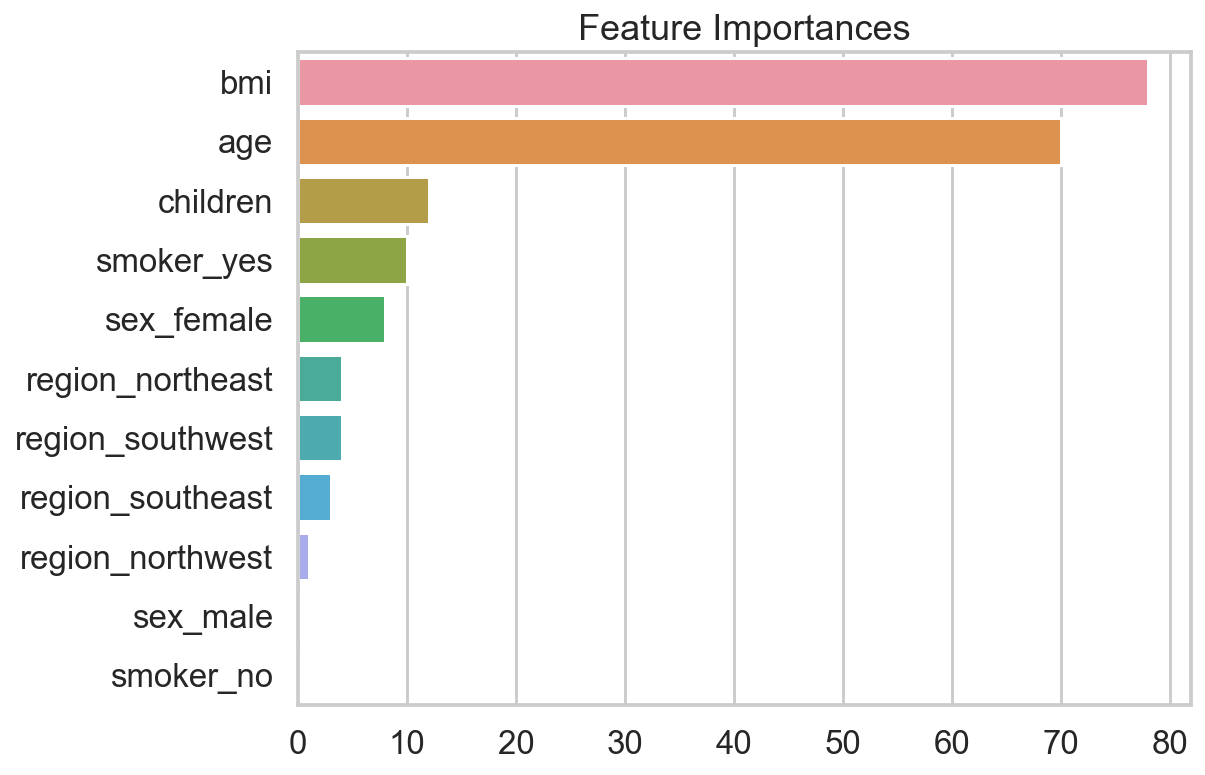

In [81]:
plt.figure(figsize=(8,6))
sns.barplot(x=feature_imp.values, y=feature_imp.index)
plt.title('Feature Importances')
plt.show()

## 4. Performance Evaluation

In [126]:
y_pred = best_est.predict(X_test)
truth = y_test.to_frame().rename(columns={'charges':'truth'}).reset_index(drop=True)
pred = pd.DataFrame({'pred':y_pred})

result = pd.concat([truth,pred],axis=1)
result['error'] = np.round(np.abs(result['truth']-result['pred']),4)
print("result.shape :",result.shape)
result.head()

result.shape : (268, 3)


,truth,pred,error
0,9095.06825,9021.558118,73.5101
1,5272.17580,6786.228225,1514.0524
2,29330.98315,24813.109941,4517.8732
3,9301.89355,10230.007257,928.1137
4,33750.29180,33965.310609,215.0188


In [115]:
get_reg_eval(y_test, y_pred)

mse : 19789542.6126
rmse : 4448.5439
r2_score : 0.8725


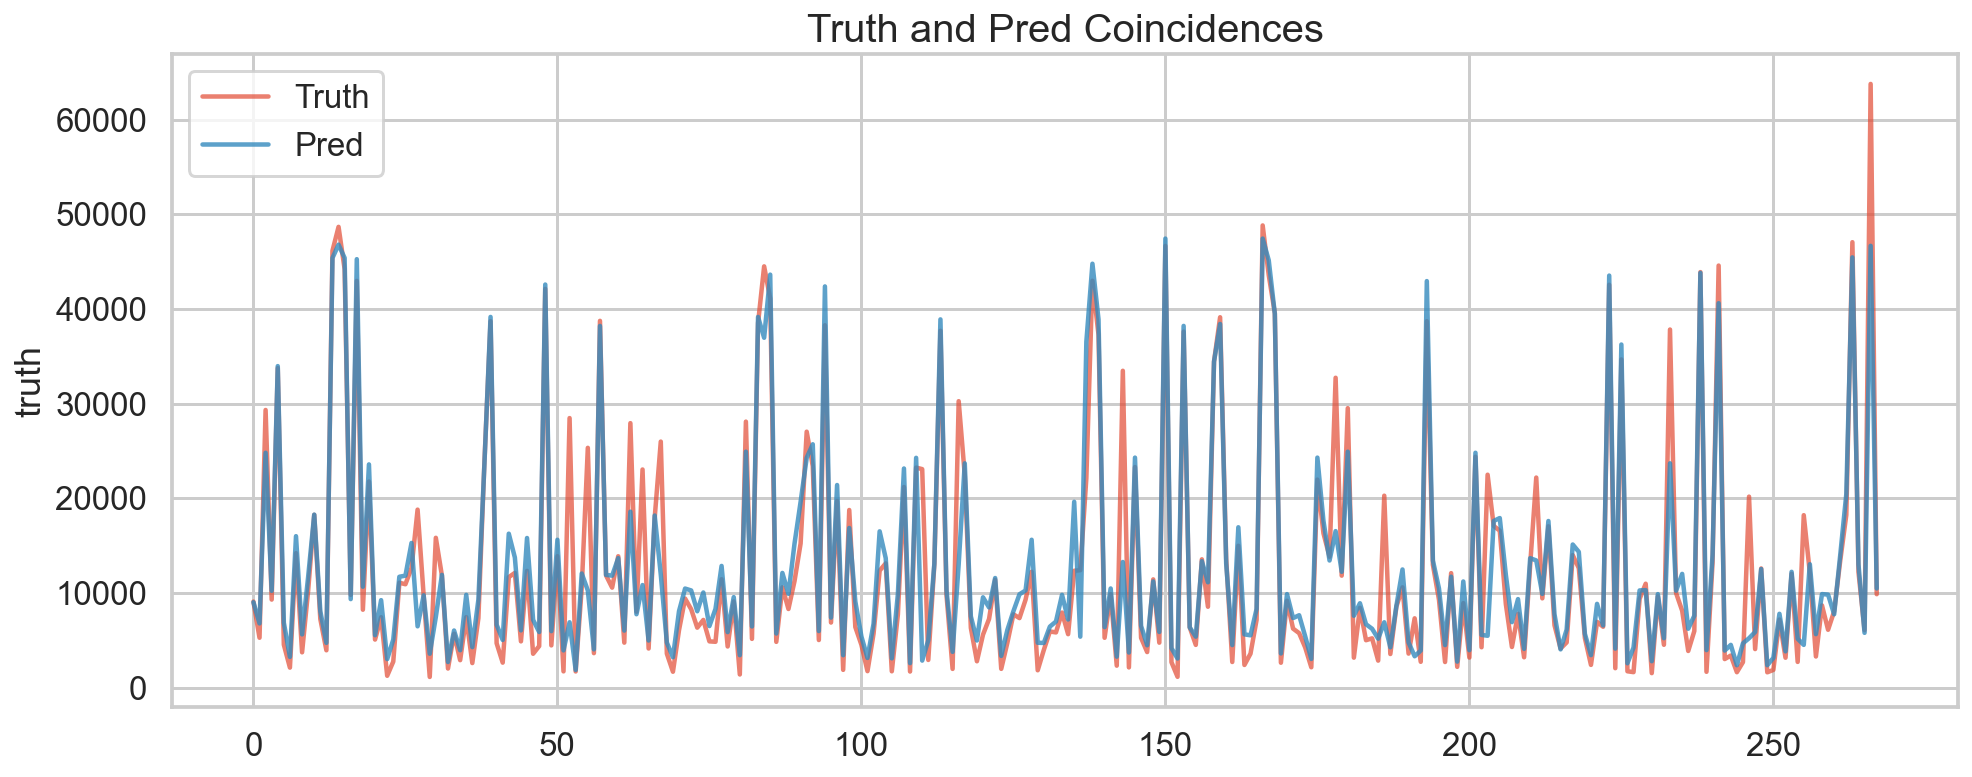

In [161]:
plt.figure(figsize=(16,6))
sns.lineplot(result.index, result['truth'], alpha=0.7, label='Truth')
sns.lineplot(result.index, result['pred'], alpha=0.8, label='Pred')
plt.title('Truth and Pred Coincidences',size=20)
plt.legend()
plt.show()

In [147]:
upper, lower= np.quantile(result['error'].values,0.75), np.quantile(result['error'].values,0.25)
iqr = upper-lower
boundary = upper + iqr*1.5
print('boundary :',np.round(boundary,4))

boundary : 4640.9892


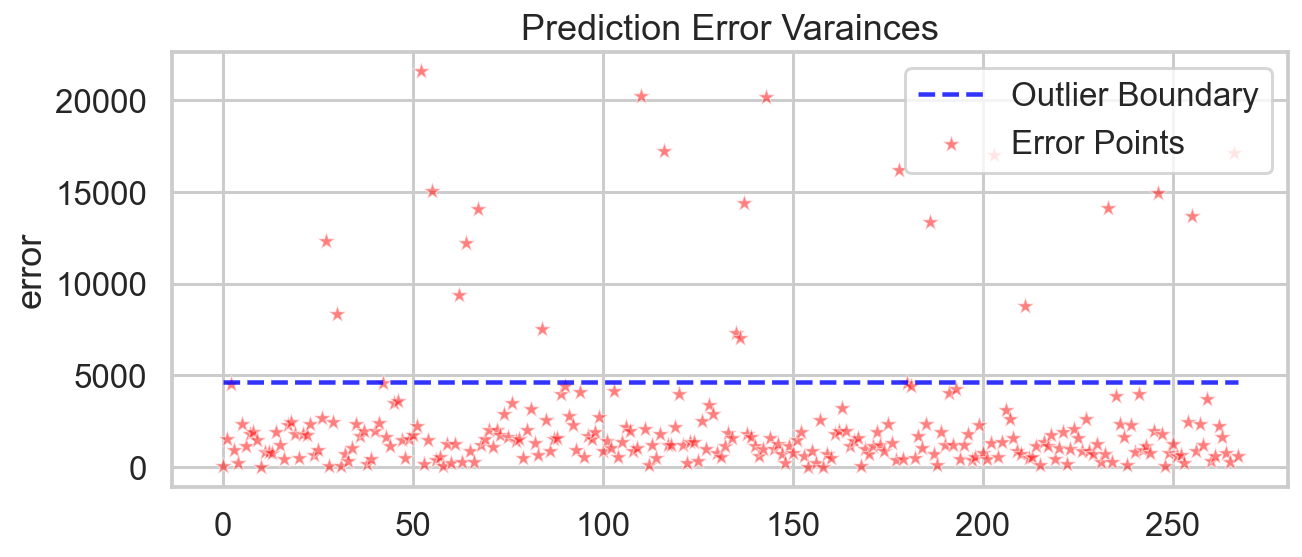

In [159]:
plt.figure(figsize=(10,4))
sns.scatterplot(result.index, result['error'], color = 'red', alpha=0.5, marker='*', label='Error Points')
sns.lineplot(result.index, boundary, color='blue', linestyle='--', label='Outlier Boundary', alpha=0.8)
plt.title('Prediction Error Varainces')
plt.legend(loc="upper right")
plt.show()